##### Estadisticas generales sobre el covid-19

In [1]:
from utilidades import *

data, aggregated_mobility, local_mobility = lazy_load_data()

x = data.index
today = data.index[-1]

In [2]:
def fast_smooth_df(df, smoothing_level=.4):
    res = pd.DataFrame([])
    
    for column in df.columns:
        if not df.loc[df.first_valid_index():, column].any():
            res[column] = df.loc[df.first_valid_index():, column]
            continue 
            
        res[column] = fast_smoothing(df.loc[df.first_valid_index():, column].dropna(), smoothing_level)
    
    res = pd.concat([df[:df.first_valid_index()], res])
    res = res[~res.index.duplicated(keep='first')]
    
    return res

def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    legend = ax.get_legend()
    ax.legend(
        loc='upper left',
        title=legend.get_title().get_text() if legend else None
    )


##### Casos

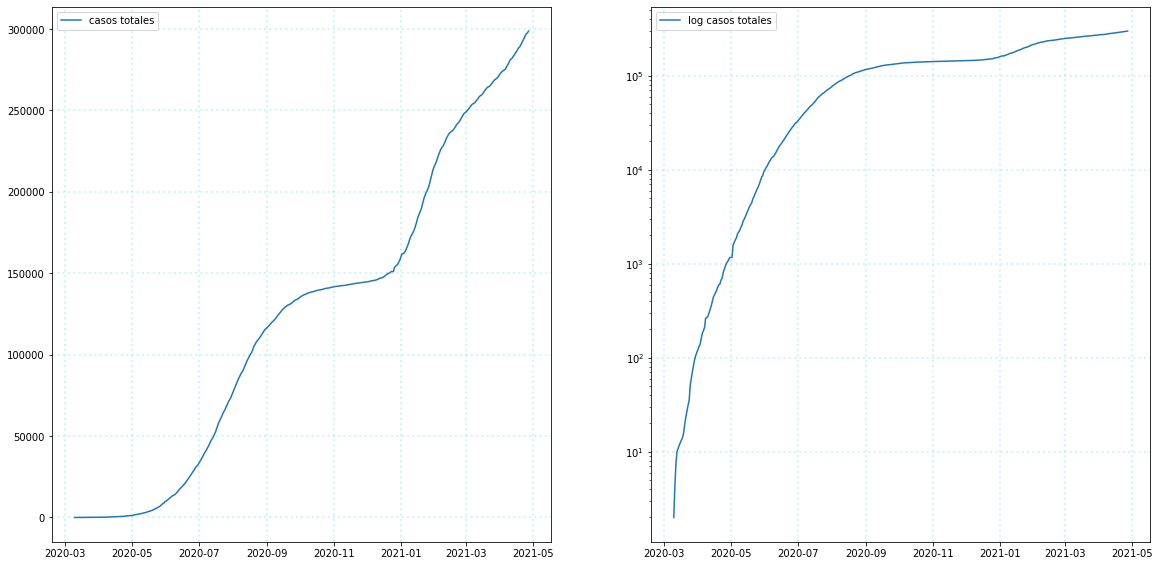

In [3]:
fig, axs = pyplot.subplots(ncols=2, nrows=1)

axs[0].plot(x, data['cases'], label='casos totales')
axs[1].plot(x, data['cases'], label='log casos totales')
axs[1].set_yscale('log')

stylize_ax(axs)

In [4]:
local_data = load_data()

local_data = local_data.swaplevel(1, 0, 1).sort_index(axis=1)[
    local_data['cases'].columns
]

In [5]:
local_death_test = local_data.loc[
    pd.IndexSlice[:],pd.IndexSlice[:,'death']
][('santa cruz', 'death')].diff()

local_death_rectified = pd.read_csv('./data/fallecidos.rectificados.csv')
local_death_rectified.index = pd.to_datetime(local_death_rectified.iloc[:, 0]).rename(None)
local_death_rectified = local_death_rectified.iloc[:, 1:]

local_death_rectified = local_death_rectified.loc['2020-05-22':'2020-10-25']
local_death_rectified.loc['2020-06-23':'2020-08-21'] = local_death_rectified.loc['2020-06-23':'2020-08-21'] - 1

local_death_test.loc[local_death_rectified.index] = local_death_rectified['santa cruz']
local_death_test = local_death_test.fillna(0)

local_data[('santa cruz', 'death')] = local_death_test.cumsum()

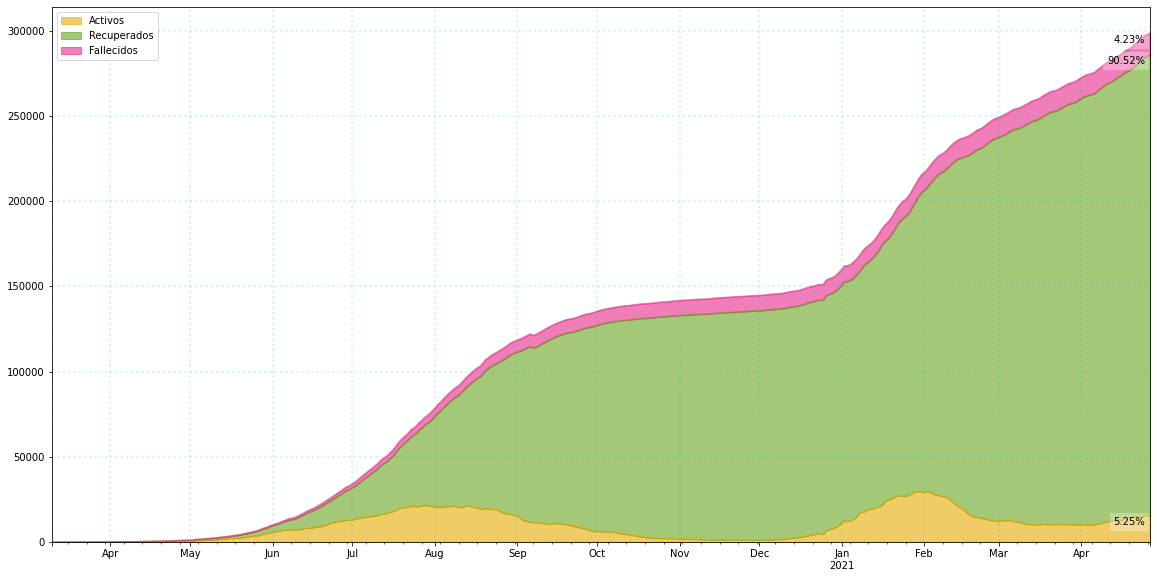

In [6]:
local_population = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,('active_cases', 'recovered', 'death')]]
local_population.columns = local_population.columns.droplevel(0)

population_states = local_population.groupby(by=local_population.columns, axis=1).sum()
population_states = population_states.loc[:, ('active_cases', 'recovered', 'death')]
population_states.columns = ['Activos', 'Recuperados', 'Fallecidos']

state_colors = cm.get_cmap('Dark2').colors[::-1][2:]
ax = population_states.plot(kind='area', alpha=.6, color=state_colors)
stylize_ax(ax)

population_total = population_states.iloc[-1].sum()
previous_value = 0

for series in ax.lines[:]:
    last_value = pd.Series(series.get_ydata())
    last_value_idx = last_value.last_valid_index()
    last_value = last_value[last_value_idx]
    
    ax.annotate(
        '{:0.2f}%'.format(100 * (last_value - previous_value) / population_total), 
        xy=(1, last_value), xytext=(-5, -10), 
        ha="right",
        xycoords=('axes fraction', 'data'), 
        textcoords='offset points',
        bbox={
            'edgecolor': 'none',
            'facecolor': 'white', 
            'alpha': 0.3
        }
    )
    
    previous_value = last_value

In [7]:
def stylize_subplots_axs(axs, annotate=True, xline=False, framealpha=None):
    for yaxs in axs:
        if isinstance(yaxs, matplotlib.axes._subplots.Axes):
            yaxs = [yaxs]
        
        for ax in yaxs:
            if not ax.lines:
                continue
            
            for series in ax.lines[:]:
                last_value_arr = pd.Series(series.get_ydata(), index=series.get_xdata())
                last_value_idx = last_value_arr.last_valid_index()
                
                if not last_value_idx or not last_value_arr[last_value_idx].any():
                    continue

                last_value = last_value_arr[last_value_idx]
                    
                if type(last_value_idx) == pd.Timestamp:
                    last_value_idx = dates.date2num(last_value_idx)
                
                if type(last_value) == pd.Series:
                    last_value = last_value[~last_value.isnull()].iloc[0]
                
                ax.plot(
                    last_value_idx, 
                    last_value, 
                    marker='D', 
                    color=series.get_color()
                )
                
                if not annotate:
                    continue
                
                ax.annotate(
                    '{:0.2f}'.format(last_value), 
                    xy=(1, last_value), xytext=(-5, 0), 
                    ha='right',
                    xycoords=('axes fraction', 'data'), 
                    textcoords='offset points',
                    bbox={
                        'edgecolor': 'none',
                        'facecolor': 'white', 
                        'alpha': 0.4
                    }
                )
                
                if not xline:
                    continue
                    
                ax.axhline(last_value, color='black', linestyle=':', alpha=.6)
            
            legend = ax.get_legend()
            ax.legend(
                loc='upper left', 
                framealpha=framealpha, 
                title=legend.get_title().get_text() if legend else None
            )
            ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
            
def local_population_plot(self, layout=None, **kwargs):
    if 'ax' in kwargs:
        axs = kwargs['ax']
        del kwargs['ax']
        
    elif layout:
        nrows, ncols = layout
        fig, axs = pyplot.subplots(ncols=ncols, nrows=nrows)
        
    else:
        fig, axs = pyplot.subplots(nrows=len(self.columns.levels[0]))
        
    plot_to_axs = axs.flatten()
    
    if 'subplots' in kwargs:
        del kwargs['subplots']

    for idx, local_key in enumerate(self.columns.droplevel(1).drop_duplicates()):
        local_population_states = pd.DataFrame(self[local_key])
        local_population_states = local_population_states.loc[:, ('active_cases', 'recovered', 'death')]

        population_total = local_population_states.iloc[-1] 
        population_total = 100 * population_total / population_total.sum()
        local_population_states.columns = [
            'A {:05.2f}%'.format(population_total['active_cases']), 
            'R {:05.2f}%'.format(population_total['recovered']), 
            'F {:05.2f}%'.format(population_total['death'])
        ]

        ax = plot_to_axs[idx]
        local_population_states.plot(ax=ax, kind='area', alpha=.6, color=state_colors)

        ax.set_title(local_key)
        ax.tick_params(labelsize=8.)
        
    return axs

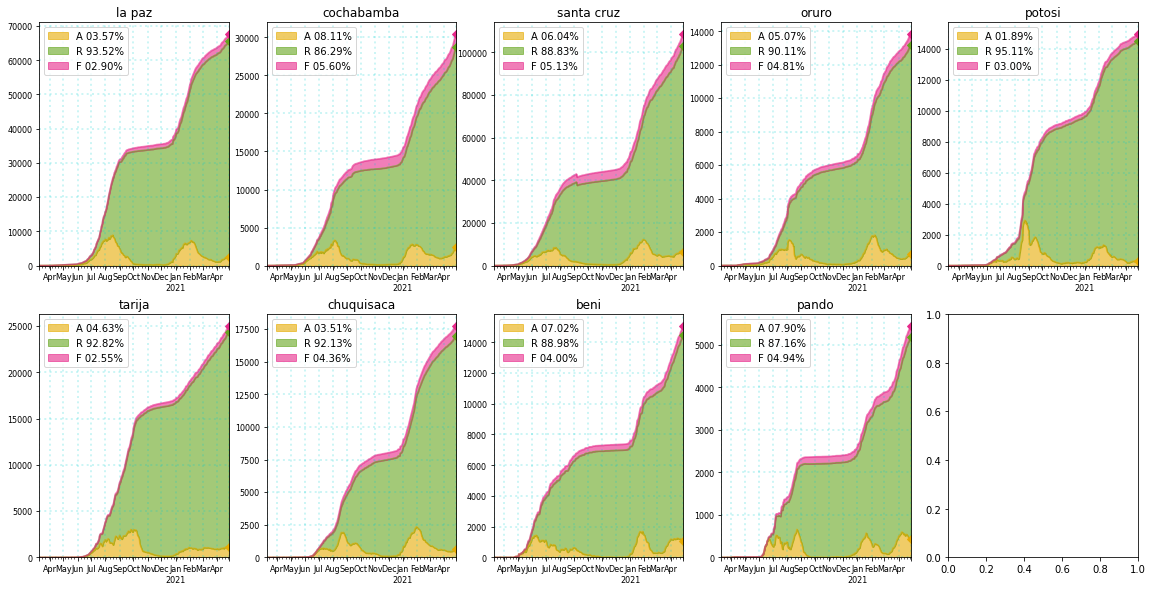

In [8]:
local_population = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,('active_cases', 'recovered', 'death')]]
local_population.plot = MethodType(local_population_plot, local_population)
axs = local_population.plot(layout=(2, 5))

stylize_subplots_axs(axs, annotate=False)

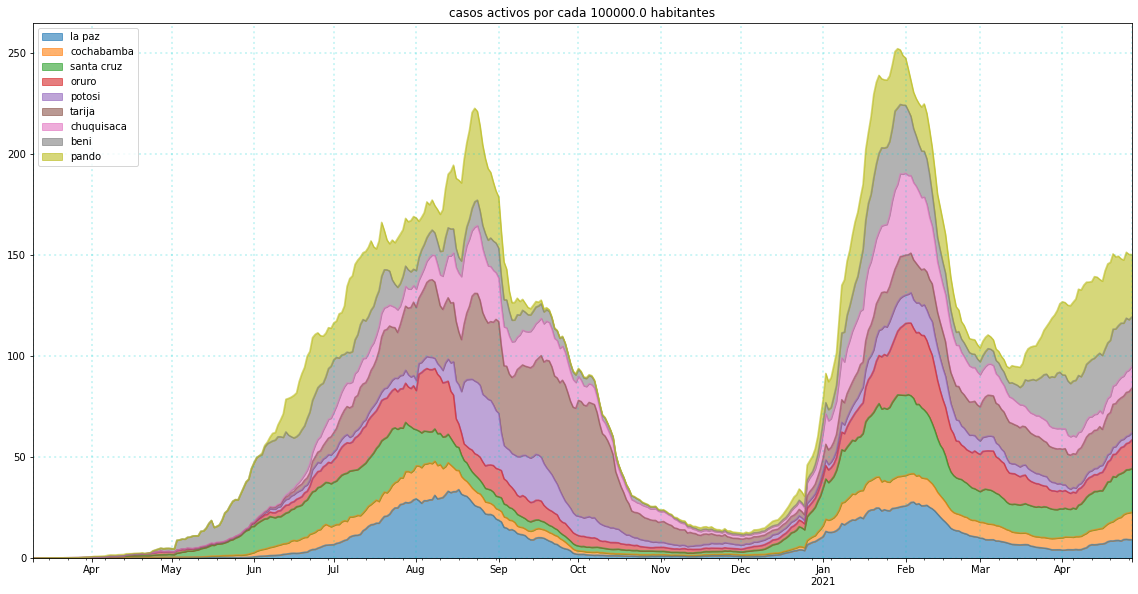

In [9]:
scale_to = 1e5

local_active_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'active_cases']]
local_active_cases.columns = local_active_cases.columns.droplevel(1)

population = load_population_data(1, group_by=2).items()
population = dict([(_[1].lower(), int(__['total'])) for _, __ in population])
population_adjust = [scale_to / population[_] for _ in local_active_cases.columns]

ax = (local_active_cases * population_adjust / 9).plot(
    title='casos activos por cada {0} habitantes'.format(scale_to), kind='area', alpha=.6
)
stylize_ax(ax)

In [10]:
active_cases_scaled = local_active_cases.sum(axis=1) * scale_to / sum(population.values())

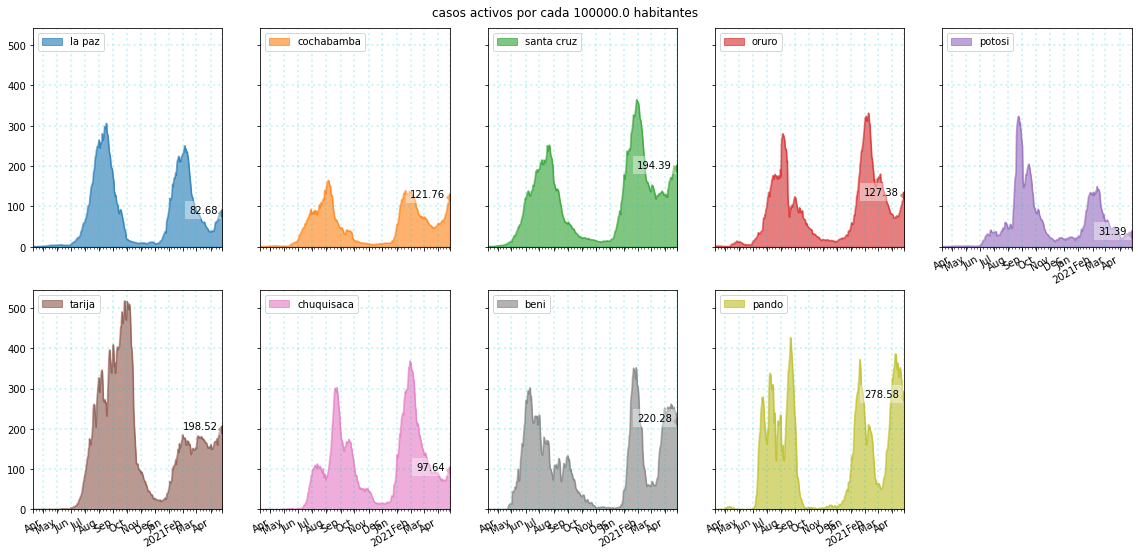

In [11]:
local_active_cases_scaled = (local_active_cases * population_adjust)

axs = local_active_cases_scaled.plot(
    subplots=True, layout=(2,5), 
    sharey=True,
    kind='area', 
    alpha=.6
#     logy=True
)

at = axs[0][0].get_figure().suptitle(
    'casos activos por cada {0} habitantes'.format(scale_to), y=.91
)
stylize_subplots_axs(axs)

In [12]:
def accumulate(arr, nth = 5):
    pad_arr = np.pad(
        arr, 
        (nth - len(arr) % nth, 0), 
        'constant', 
        constant_values=(0,)
    )
    return np.reshape(pad_arr, (-1, nth)).sum(axis=-1)

def plot_accumulated(x, y = None, label = '', nth = 5):
    if y is None:
        y = x
        x = range(len(y))
        
    fig, ax = pyplot.subplots()
    ax.stem(x, y, label=label)
    
    cum_y = accumulate(y, nth)
    cum_y = np.repeat(cum_y, nth)[-1 * len(x):]
    
    ax2 = ax.twinx()
    ax2.step(x, cum_y, color='green', label='{} (Acumulado {} dias)'.format(label, nth))
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    if label:
        fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
        
    return ax

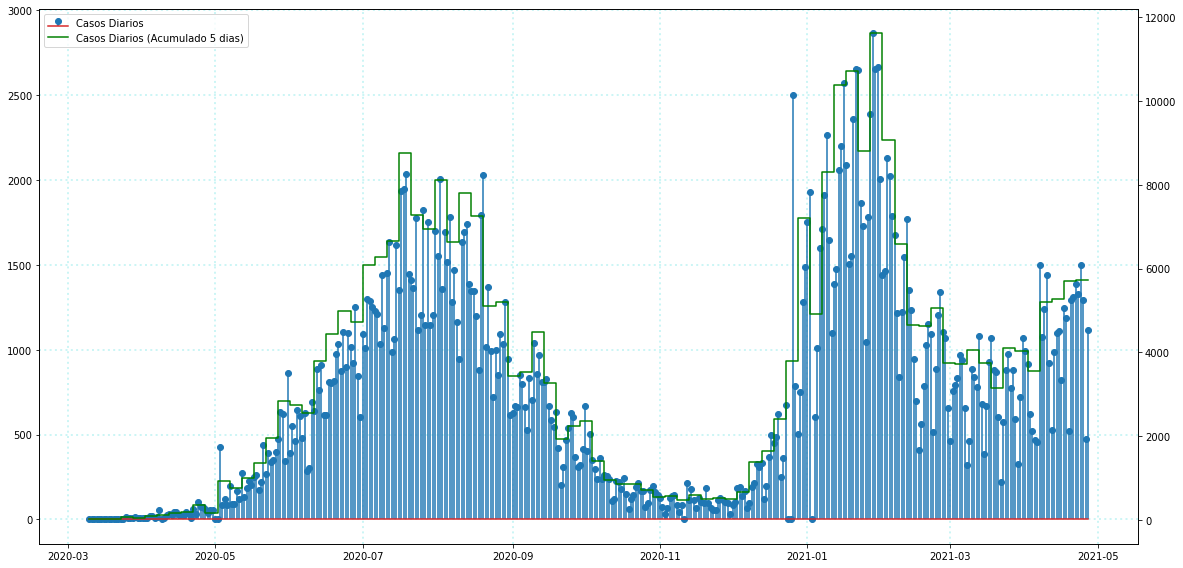

In [13]:
new_cases = data['cases'].diff()
new_cases[np.isnan(new_cases)] = 0

_ = plot_accumulated(x, new_cases, label='Casos Diarios')

###### R_t 

avg Rt m1 (30d): R_t    1.105626
dtype: float64
r_ts[-1]: 1.0263130670672642 +- 0.0596635070892102


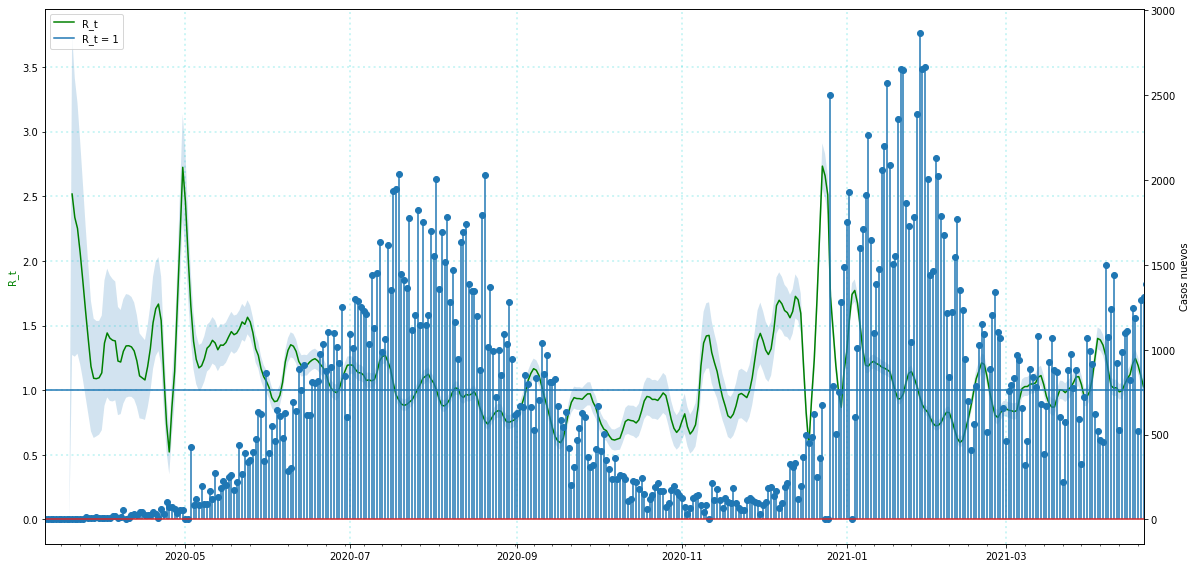

In [14]:
r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=5)
r_ts[r_ts < 0.01] = np.nan

r_ts = pd.DataFrame(r_ts, index=x[:-6], columns=['R_t'])
rts_base_plot = r_ts.plot

def rts_plot(self, **kwargs):
    if 'ax' in kwargs:
        ax = kwargs['ax']
        del kwargs['ax']
    else:
        fig, ax = pyplot.subplots()
        
    rts_base_plot(ax=ax, **kwargs)
    ax.fill_between(
        ax.lines[0].get_xdata(),
        r_ts_min,
        r_ts_max,
        alpha=0.2
    )
    
    return ax
    
r_ts.plot = MethodType(rts_plot, r_ts)

ax = r_ts.plot(color='green', label='R_t estimado')
ax.set_ylabel('R_t', color='green')

ax2 = ax.twinx()
ax2.stem(x, new_cases)
ax2.set_ylabel('Casos nuevos')


print('avg Rt m1 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts[r_ts > 0][-30:]),
    r_ts.iloc[-1].values[0], r_ts_max[-1] - r_ts.iloc[-1].values[0]
))

ax.axhline(1., label='R_t = 1')
stylize_ax(ax)

Refs   
[1]: https://stochastik-tu-ilmenau.github.io/COVID-19/reports/repronum/repronum.pdf   
[2]: https://biocomsc.upc.edu/en/covid-19/Methods.pdf/view

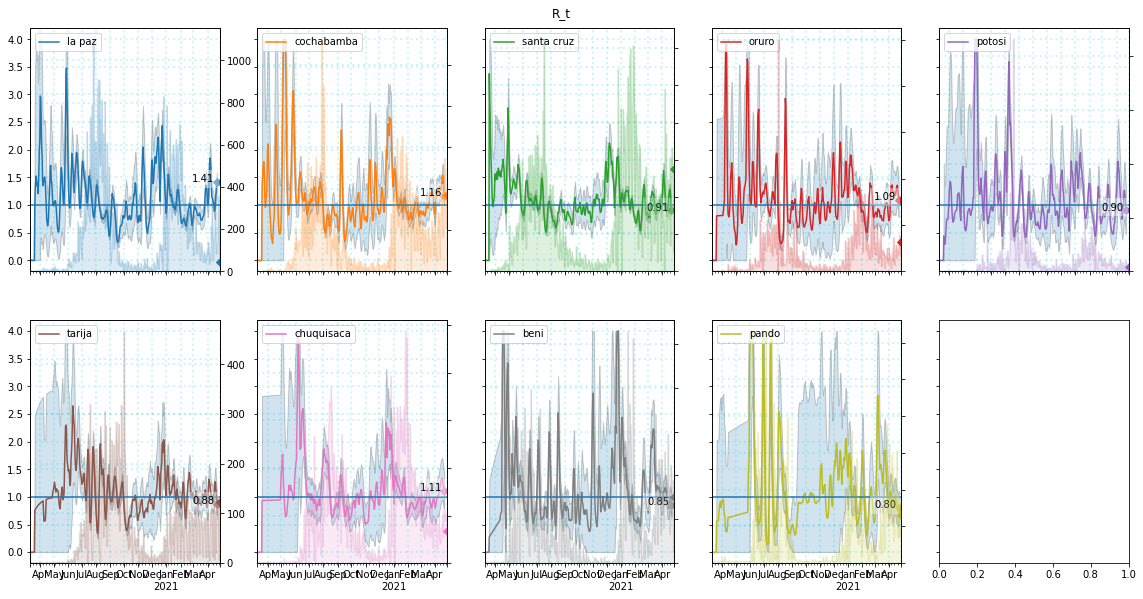

In [15]:
local_new_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']].diff()
local_new_cases[np.isnan(local_new_cases)] = 1
local_new_cases[local_new_cases < 1e-6] = 1
local_new_cases.columns = local_new_cases.columns.droplevel(1) 

local_rts = pd.DataFrame(index=x)
uncertainty_rts = pd.DataFrame()

do_pad = lambda arr:  np.pad(arr, (0, 6), 'constant', constant_values=(np.nan,))

for column in local_new_cases.columns:
    lr_ts, lr_ts_min, lr_ts_max = estimate_rt(local_new_cases[column].fillna(1), window_size=5)
    local_rts[column] = do_pad(lr_ts)
    uncertainty_rts[column] = [do_pad(lr_ts_min), do_pad(lr_ts_max)]
    
R_TS_MAX = 4
def local_rts_plot(self, layout=None, **kwargs):
    if 'ax' in kwargs:
        axs = kwargs['ax']
        del kwargs['ax']
        
    elif layout:
        if 'sharey' in kwargs:
            del kwargs['sharey']
            
        nrows, ncols = layout
        fig, axs = pyplot.subplots(ncols=ncols, nrows=nrows, sharey=True)
        
    else:
        fig, axs = pyplot.subplots(nrows=len(self.columns.levels[0]))
        
    plot_to_axs = axs.flatten()
    plot_to_axs = plot_to_axs[:len(self.columns)]
    
    if 'subplots' in kwargs:
        del kwargs['subplots']
                
    local_rts_base_plot(subplots=True, ax=plot_to_axs, **kwargs)
    
    if not 'kind' in kwargs:
        for ax in plot_to_axs:
            column = ax.get_legend()
            if not column:
                continue

            column = ax.get_legend().texts[0].get_text()
            lr_ts_min, lr_ts_max = uncertainty_rts[column]
            lr_ts_min[lr_ts_min > R_TS_MAX] = R_TS_MAX
            lr_ts_max[lr_ts_max > R_TS_MAX] = R_TS_MAX
            
            ax.fill_between(
                ax.lines[0].get_xdata(), 
                lr_ts_min[-1 * len(self):], lr_ts_max[-1 * len(self):],
                alpha=0.2,
                edgecolor='black'
            )
        
    return plot_to_axs

local_rts[local_rts > R_TS_MAX] = R_TS_MAX
local_rts_base_plot = local_rts.plot
local_rts.plot = MethodType(local_rts_plot, local_rts)
axs = local_rts.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
)
stylize_subplots_axs(axs)

for ax in axs:
    ax.axhline(1.)
            
axs = local_new_cases.plot(
    kind='area', 
    ax=[ax.twinx() for ax in axs], 
    subplots=True,
    alpha=0.15,
    sharey=True
)

at = axs[0].get_figure().suptitle(
    'R_t'.format(scale_to), y=.91
)
stylize_subplots_axs(axs, annotate=False)

for ax in axs:
    ax.get_legend().remove()

Tiempo de duplicacion

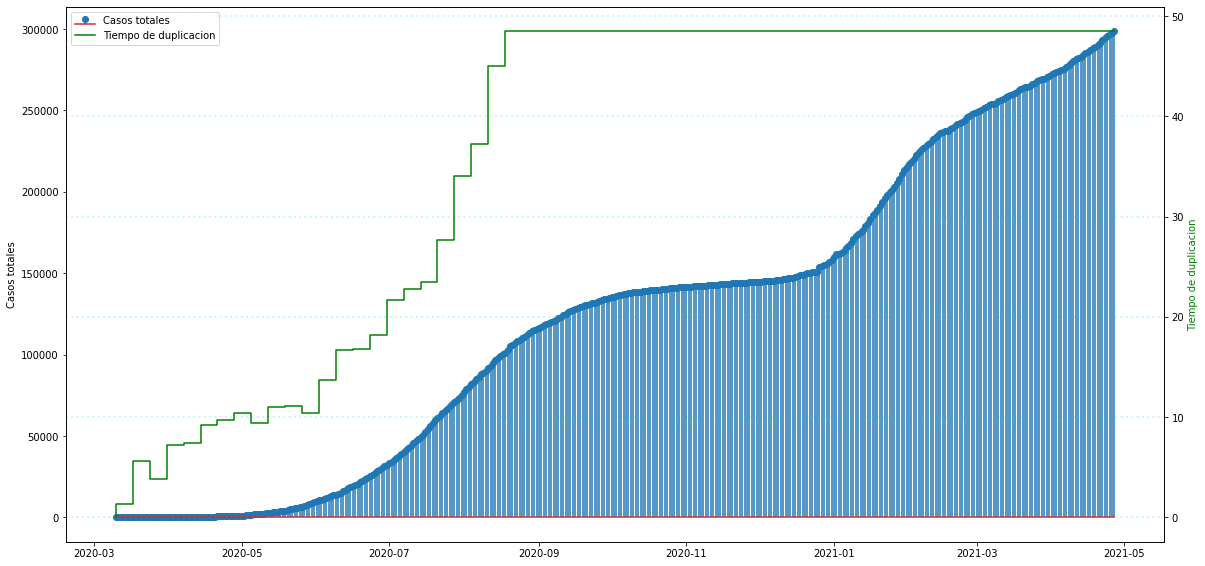

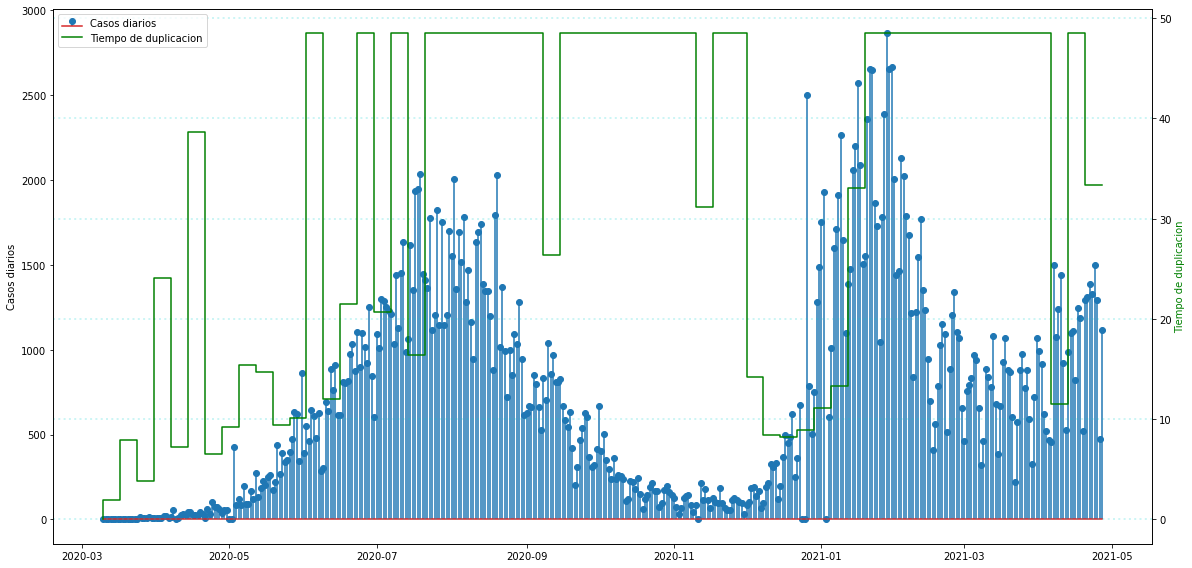

In [16]:
NTH = 7

# razon_incremento^x = 2
def doubling_times(arr):
    dts = [0]
    cum_arr = accumulate(arr, nth=NTH)
    
    for idx in range(1, len(cum_arr)):
        diff = max(
            1, cum_arr[idx] / max(1., cum_arr[idx - 1])
        )
        dts.append(NTH * np.log(2) / max(.1, np.log(diff)))
    
    return dts

def draw_doubling(arr, title=''):
    dts = doubling_times(arr)
    dts = np.repeat(dts, NTH)[-1 * len(arr):]

    fig, ax = pyplot.subplots()
    p1 = ax.stem(x, arr, label=title)
    ax.set_ylabel(title)

    ax2 = ax.twinx()
    ax2.set_ylabel('Tiempo de duplicacion', color='green')
    p2 = ax2.step(x, dts, color='green', label='Tiempo de duplicacion')

    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
    
draw_doubling(data['cases'], title='Casos totales')
draw_doubling(new_cases, title='Casos diarios')

###### Movilidad

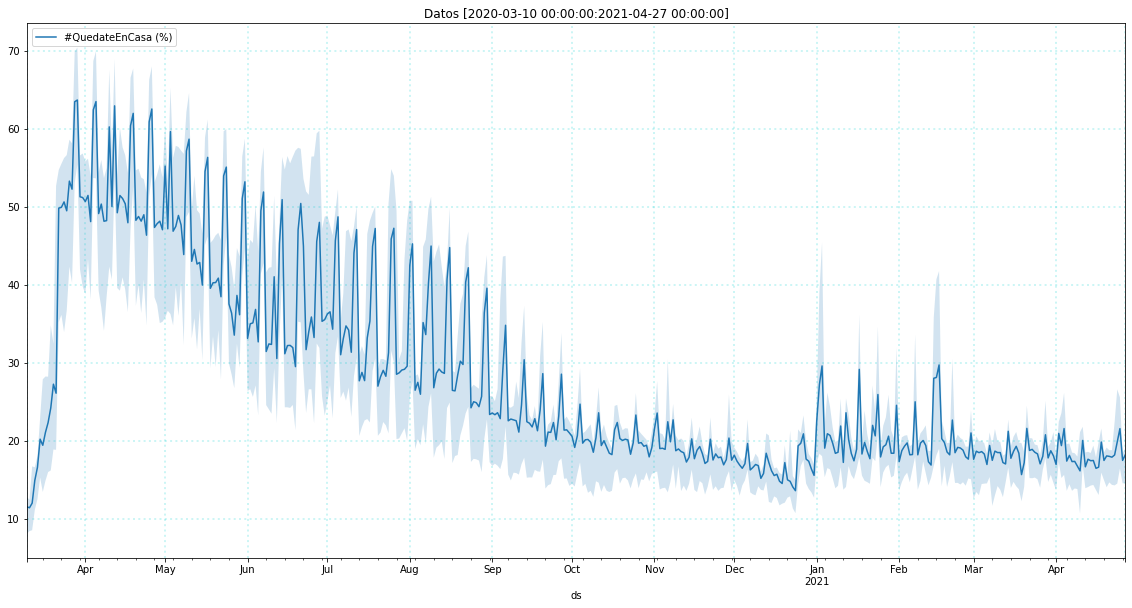

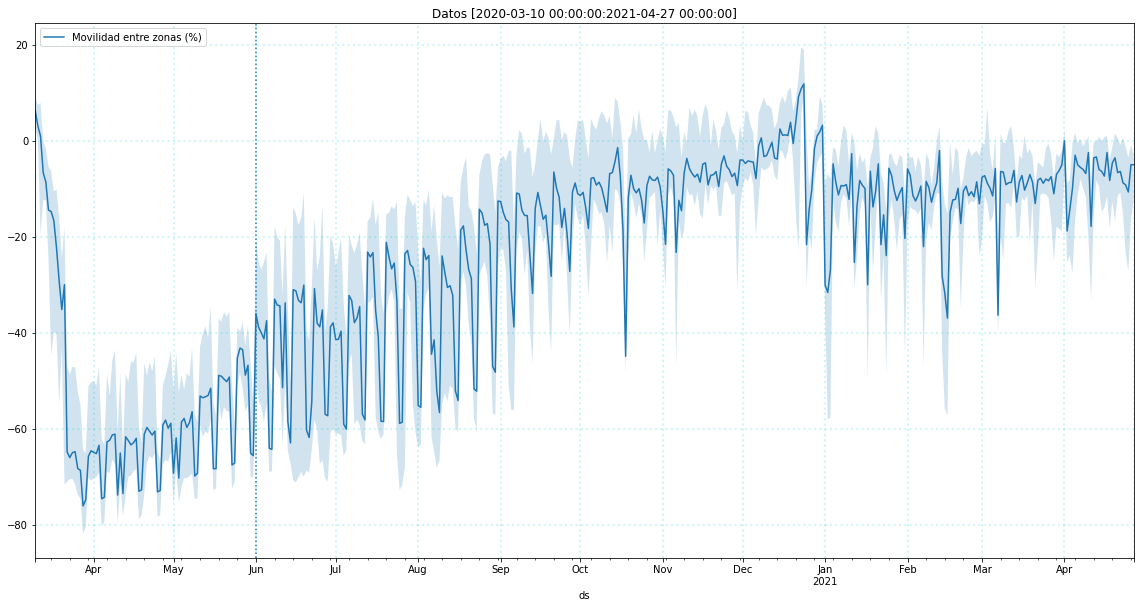

In [17]:
def plot_with_min_max(global_mobility, local_mobility, title):
    global_mobility = global_mobility.loc['2020-03-10':]
    local_mobility = local_mobility.loc['2020-03-10':]
    
#     ax = plot(
#         global_mobility.index, 
#         global_mobility * 100, 
#         labels=[title]
#     )
    mobility_data = global_mobility * 100
    mobility_data.columns = [title]
    ax = mobility_data.plot()
    
    ax.fill_between(
        local_mobility.index,
        local_mobility.min(axis=1) * 100,
        local_mobility.max(axis=1) * 100,
        alpha=0.2
    )
    
    ax.set_title('Datos [{}:{}]'.format(
        global_mobility.index[0], global_mobility.index[-1]
    ))
    
    stylize_ax(ax)
    
    return ax
    
if aggregated_mobility:
    visited_tiles_change, single_tile_ratio = aggregated_mobility
    visited_tiles_change.index = pd.to_datetime(visited_tiles_change.index)
    single_tile_ratio.index = pd.to_datetime(single_tile_ratio.index)
    
    visited_tiles_change_local, single_tile_ratio_local = local_mobility
    
    plot_with_min_max(single_tile_ratio, single_tile_ratio_local, '#QuedateEnCasa (%)')
    ax = plot_with_min_max(visited_tiles_change, visited_tiles_change_local, 'Movilidad entre zonas (%)')
    
    ax.axvline('2020-06-01', linestyle=':')
    

Cambio en el comportamiento respecto a febrero.   
Fuente: https://data.humdata.org/dataset/movement-range-maps   
   
En la <a href='https://research.fb.com/blog/2020/06/protecting-privacy-in-facebook-mobility-data-during-the-covid-19-response/'>metodologia</a> facebook aclara que: `Only people who opt in to Location History and background location collection are included`   


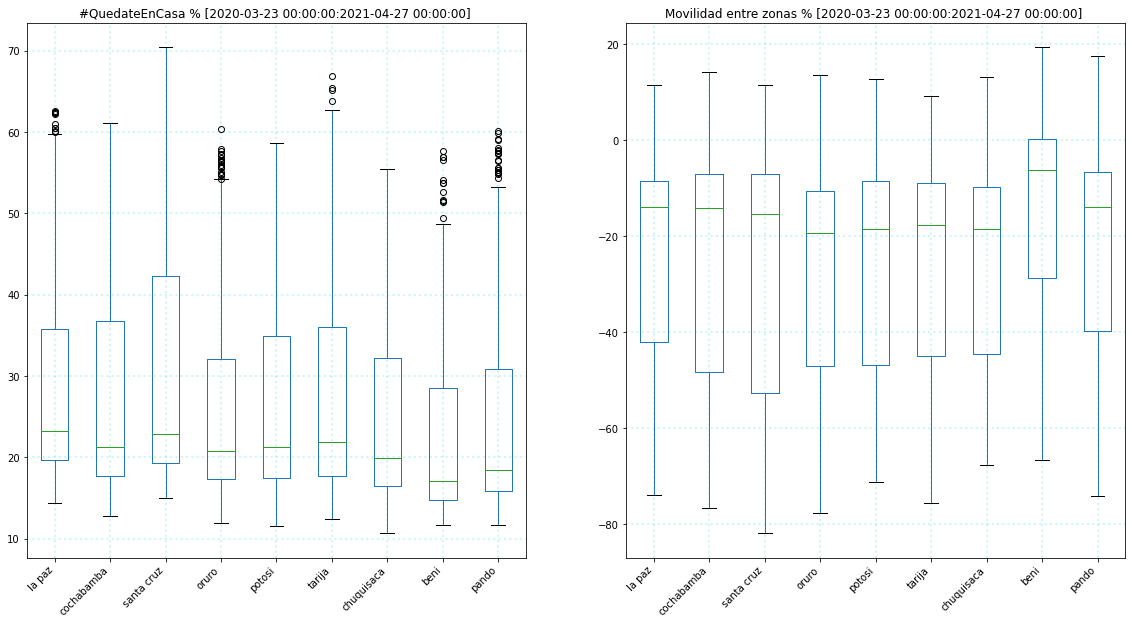

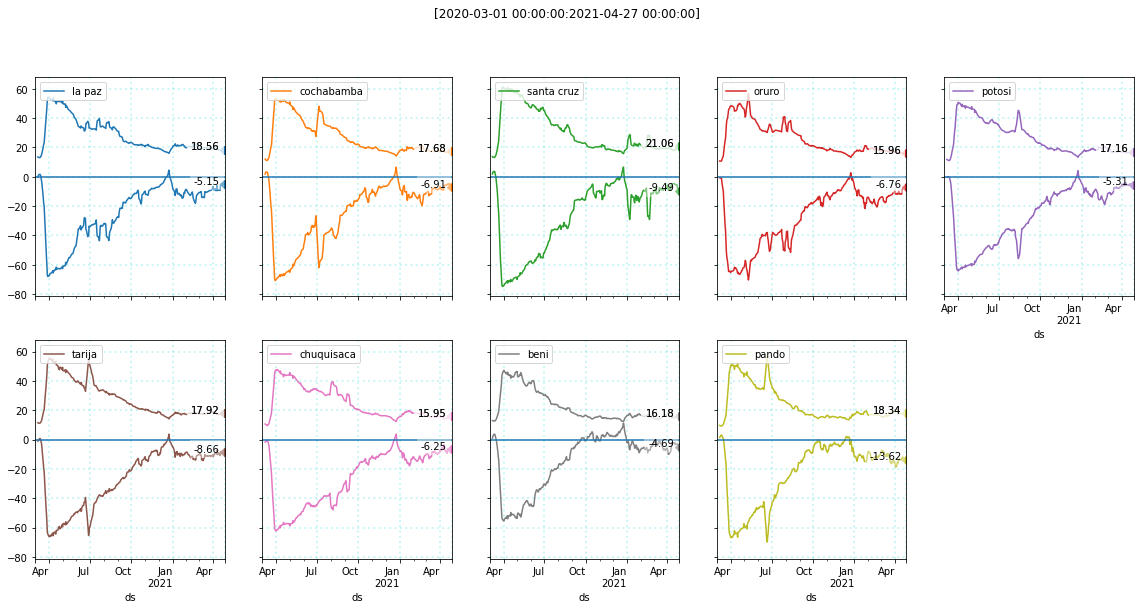

In [18]:
def draw_boxplot(data, title, ax, to_date=None):
    data = data.loc['2020-03-23':] * 100
    data.boxplot(ax=ax)
    to_date = to_date if to_date is not None else data.iloc[-1].name
    
    ax.set_title('{} % [{}:{}] '.format(
        title,
        data.iloc[0].name,
        to_date
    ))
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

def plot_latest(data, nth=None, axs=None, to_date=None):
    latest_data = data
    if nth is not None:
        latest_data = data.tail(nth)
        
    latest_data = latest_data * 100
        
    to_date = to_date if to_date is not None else latest_data.iloc[-1].name
    
    if axs is None:
        axs = latest_data.plot(
            title='[{}:{}]'.format(
                latest_data.iloc[0].name, 
                to_date
            ),
            subplots=True, 
            layout=(2,5), 
            sharey=True, 
        )
        
    else:
        axs = latest_data.plot(
            ax=axs.flatten()[:-1] if axs is not None else None,
            subplots=True, 
            legend=False
        )
        
    stylize_subplots_axs(axs)
    
    for ax in axs:
        if isinstance(ax, matplotlib.axes._subplots.Axes):
            ax.axhline(0)
            
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            
            ax.legend(
                by_label.values(), 
                by_label.keys(), 
                loc='upper left'
            )
    
    return axs

if local_mobility:
    fig, axs = pyplot.subplots(ncols=2, nrows=1)
    column_order = local_data.columns.get_level_values(0).drop_duplicates()
    
    single_tile_ratio_local = single_tile_ratio_local[column_order][:]
    
    to_date = single_tile_ratio_local.index[-1]
    for pad_date in pd.date_range(to_date, today):
        single_tile_ratio_local.loc[pad_date] = np.nan

    visited_tiles_change_local = visited_tiles_change_local[column_order][:]
    
    for pad_date in pd.date_range(to_date, today):
        visited_tiles_change_local.loc[pad_date] = np.nan

#     visited_tiles_change_local.index = pd.to_datetime(visited_tiles_change_local.index)
        
    draw_boxplot(
        single_tile_ratio_local, 
        title='#QuedateEnCasa', 
        ax=axs[0], 
        to_date=to_date
    )
    draw_boxplot(
        visited_tiles_change_local, 
        title='Movilidad entre zonas', 
        ax=axs[1], 
        to_date=to_date
    )
    
    axs = plot_latest(single_tile_ratio_local.rolling(window=7).mean(), to_date=to_date)
    plot_latest(visited_tiles_change_local.rolling(window=7).mean(), axs=axs, to_date=to_date)

##### Fallecidos

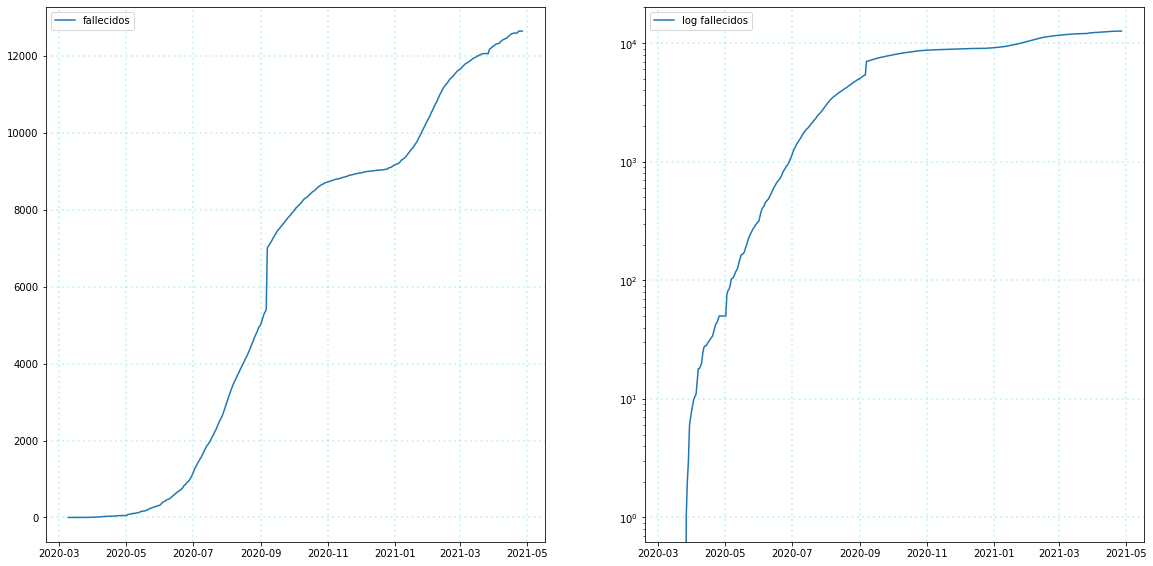

In [19]:
fig, axs = pyplot.subplots(ncols=2, nrows=1)

axs[0].plot(x, data['death'], label='fallecidos')
axs[1].plot(x, data['death'], label='log fallecidos')
axs[1].set_yscale('log')

stylize_ax(axs)

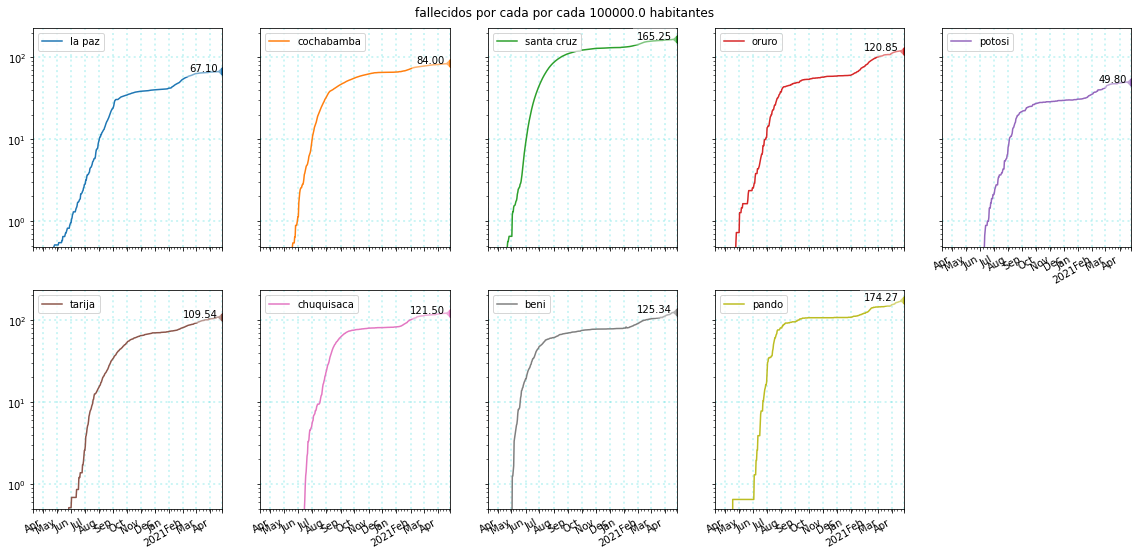

In [20]:
local_deaths_adjusted = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'death']]
local_deaths_adjusted = (local_deaths_adjusted * population_adjust)
local_deaths_adjusted.columns = local_deaths_adjusted.columns.droplevel(1)

axs = local_deaths_adjusted.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
    logy=True
)

at = axs[0][0].get_figure().suptitle(
    'fallecidos por cada por cada {0} habitantes'.format(scale_to), y=.91
)
stylize_subplots_axs(axs)

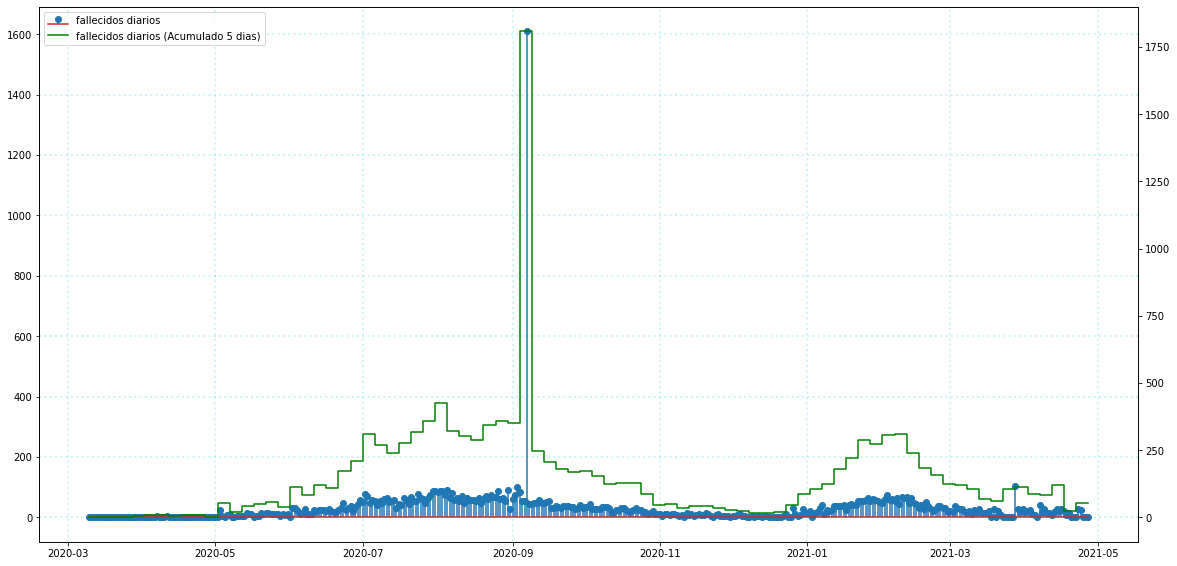

In [21]:
daily_deaths = data['death'].diff()
daily_deaths[np.isnan(daily_deaths)] = 0

_ = plot_accumulated(x, daily_deaths, label='fallecidos diarios')

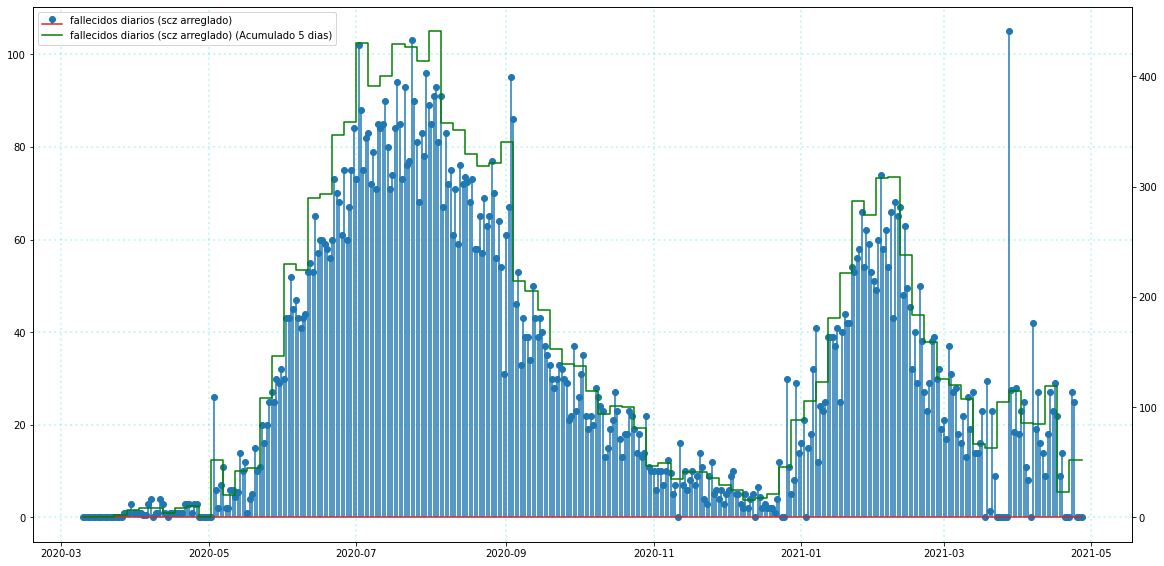

In [22]:
local_deaths = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'death']]
local_deaths.columns = local_deaths.columns.droplevel(1)

daily_deaths = local_deaths.sum(axis=1).diff()
daily_deaths[np.isnan(daily_deaths)] = 0

_ = plot_accumulated(x, daily_deaths, label='fallecidos diarios (scz arreglado)')

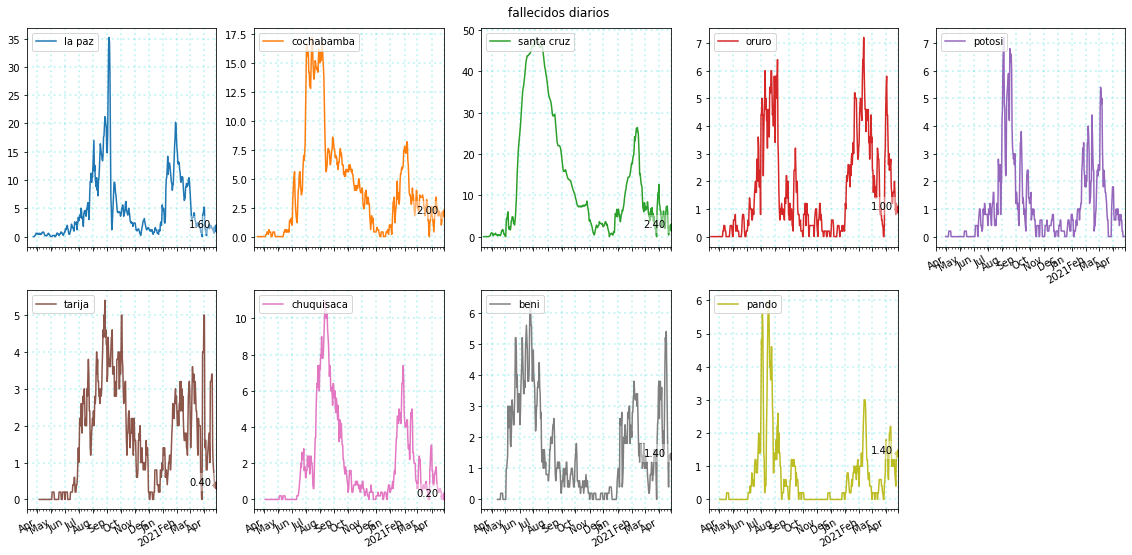

In [23]:
local_daily_deaths = local_deaths.diff()
local_daily_deaths[local_daily_deaths < 0] = 0

axs = local_daily_deaths.rolling(window=5).mean().plot(
    subplots=True, 
    layout=(2,5), 
)

at = axs[0][0].get_figure().suptitle(
    'fallecidos diarios', y=.91
)
stylize_subplots_axs(axs)

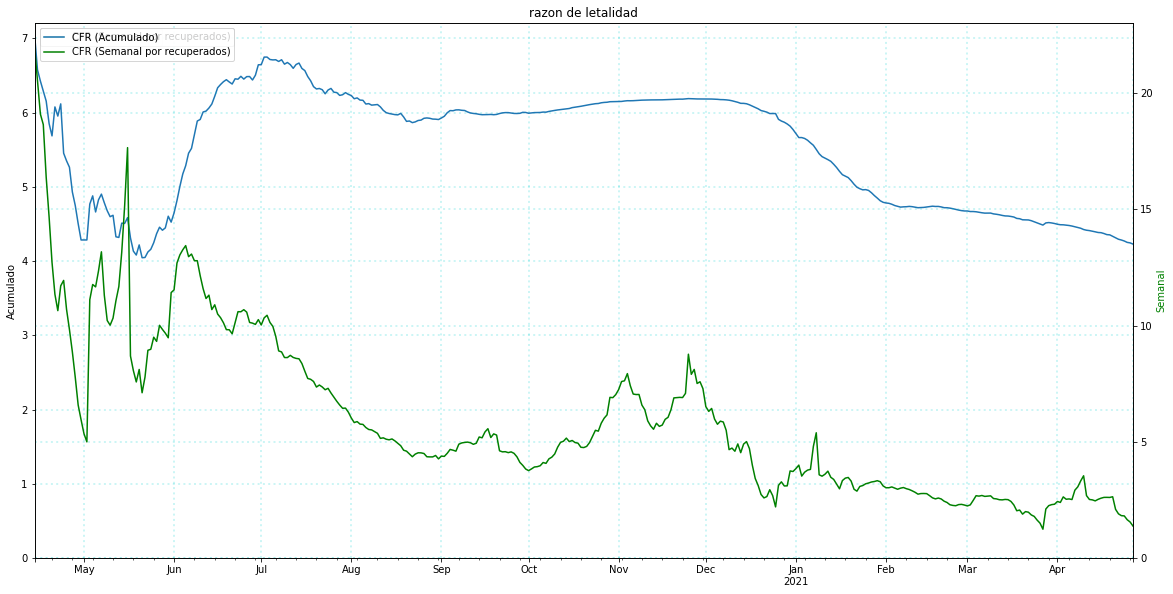

In [24]:
cfr = 100 * daily_deaths.cumsum() / data['cases']
cfr[cfr == 0] = np.nan

local_recovered = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'recovered']]
local_recovered.columns = local_recovered.columns.droplevel(1)
weekly_recovered = local_recovered.diff().sum(axis=1).rolling(window=14).sum()

cfr_shifted_weekly = daily_deaths.rolling(window=14).sum()
cfr_shifted_weekly = 100 * cfr_shifted_weekly / (weekly_recovered + cfr_shifted_weekly)

ax1 = cfr['2020-04-14':].plot(label='CFR (Acumulado)', title='razon de letalidad')
ax1.set_ylabel('Acumulado')

ax2 = cfr_shifted_weekly['2020-04-14':].plot(
    label='CFR (Semanal por recuperados)', 
    ax=ax1.twinx(), 
    color='green'
)
ax2.set_ylabel('Semanal', color='green')

ax1.set_ylim(0, ax1.get_ylim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])

stylize_ax(ax1)
stylize_ax(ax2)

ax1.get_figure().legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

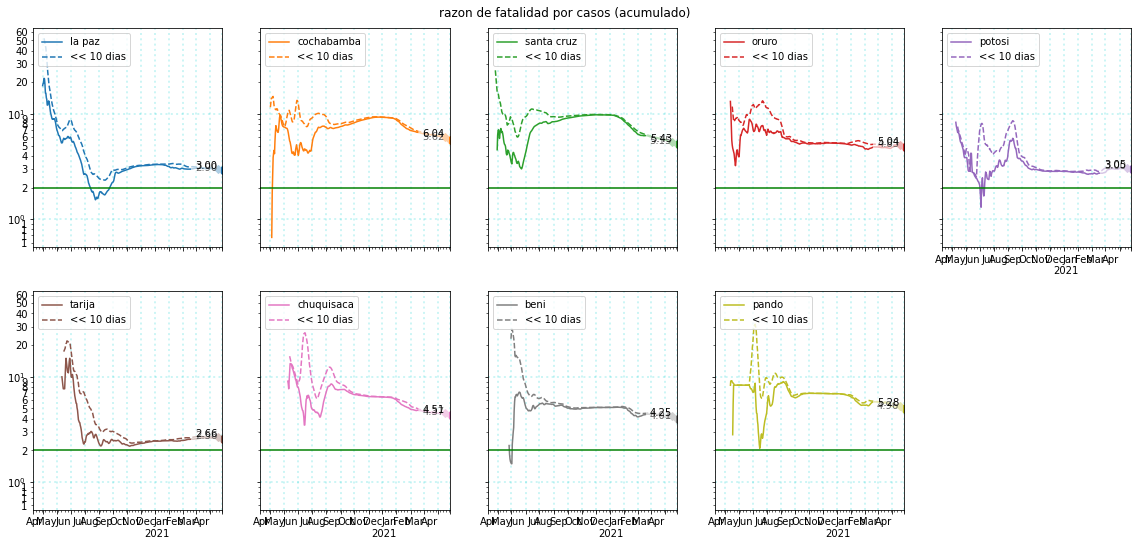

In [25]:
SHIFT_NTH = 10
limit_local_cases = 10

local_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']]
local_cases = pd.DataFrame(local_cases)
local_cases = local_cases[local_cases >= limit_local_cases]
local_cases.columns = local_cases.columns.droplevel(1) 

cfr = (100 * local_deaths.rolling(window=3).sum() / local_cases.rolling(window=3).sum())
# cfr = cfr.rolling(window=3).mean()
cfr[cfr == 0] = np.nan
cfr[:21] = np.nan

axs = cfr.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
    logy=True
)

shifted_cfr = local_deaths.shift(periods=-1 * SHIFT_NTH)
shifted_cfr = (100 * shifted_cfr / local_cases)

shifted_cfr = shifted_cfr.rolling(window=7).mean()
shifted_cfr[shifted_cfr == 0] = np.nan

shifted_cfr.plot(ax=axs.flatten()[:-1], subplots=True, linestyle='--')

at = axs[0][0].get_figure().suptitle(
    'razon de fatalidad por casos (acumulado)', y=.91
)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        dashed = ax.get_lines()[:2]
        if not dashed:
            continue
            
        ax.legend(
            dashed, [
                dashed[0].get_label(),
                '<< {} dias'.format(SHIFT_NTH)
            ], 
            loc='upper left'
        )
        ax.axhline(2., color='green')
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

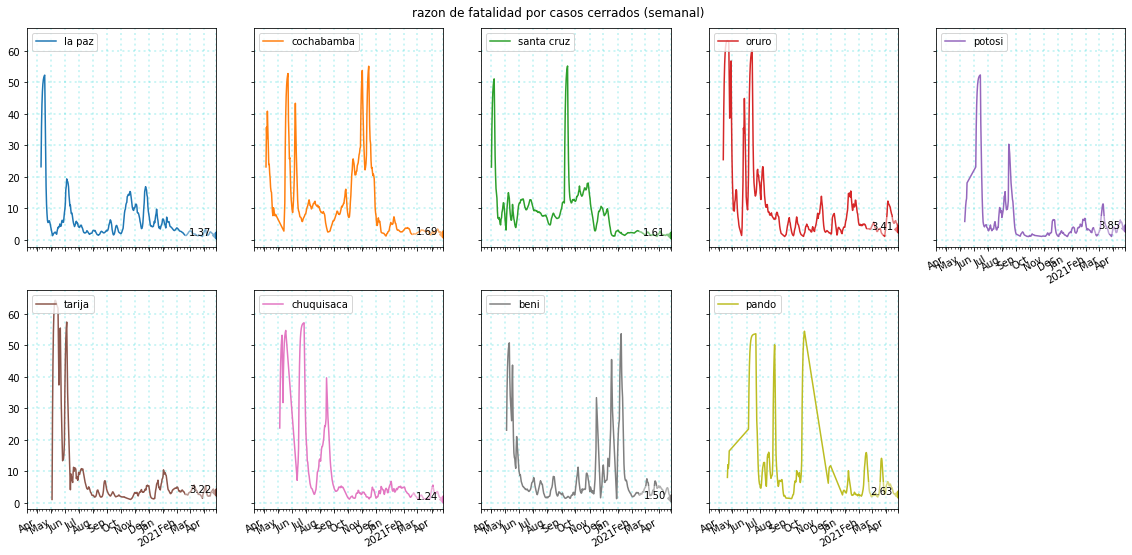

In [26]:
local_recovered = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'recovered']]
local_recovered.columns = local_recovered.columns.droplevel(1)
local_daily_recovered = local_recovered.diff()

local_weekly_recovered = local_daily_recovered.rolling(window=7).sum()
local_weekly_recovered[local_weekly_recovered < 1] = 0

local_weekly_death = local_daily_deaths.rolling(window=7).sum()

local_weekly_cfr = 100 * local_weekly_death / (local_weekly_recovered + local_weekly_death)

local_weekly_cfr[local_weekly_cfr > 100] = np.nan
local_weekly_cfr = local_weekly_cfr.fillna(method='ffill')

local_weekly_cfr[local_weekly_cfr < 1] = 0
local_weekly_cfr = local_weekly_cfr.fillna(0)
local_weekly_cfr[local_weekly_cfr > 33] = 60

# local_weekly_cfr = local_weekly_cfr.rolling(window=5).mean()
local_weekly_cfr = fast_smooth_df(local_weekly_cfr)
# local_weekly_cfr = local_weekly_cfr.apply(
#     lambda _: fast_smoothing(_, smoothing_level=.15)
# )

local_weekly_cfr[:21] = np.nan
local_weekly_cfr[local_weekly_cfr < 1] = np.nan

local_weekly_cfr = local_weekly_cfr.interpolate('linear')


axs = local_weekly_cfr.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
)

at = axs[0][0].get_figure().suptitle(
    'razon de fatalidad por casos cerrados (semanal)', y=.91
)
stylize_subplots_axs(axs)

###### Tiempo de Duplicacion

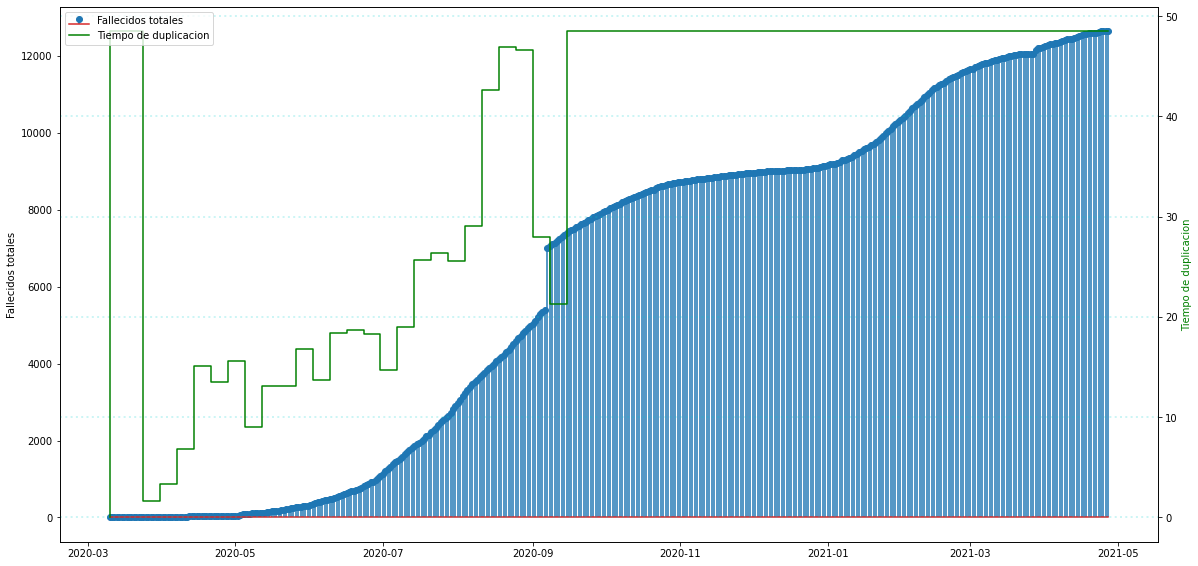

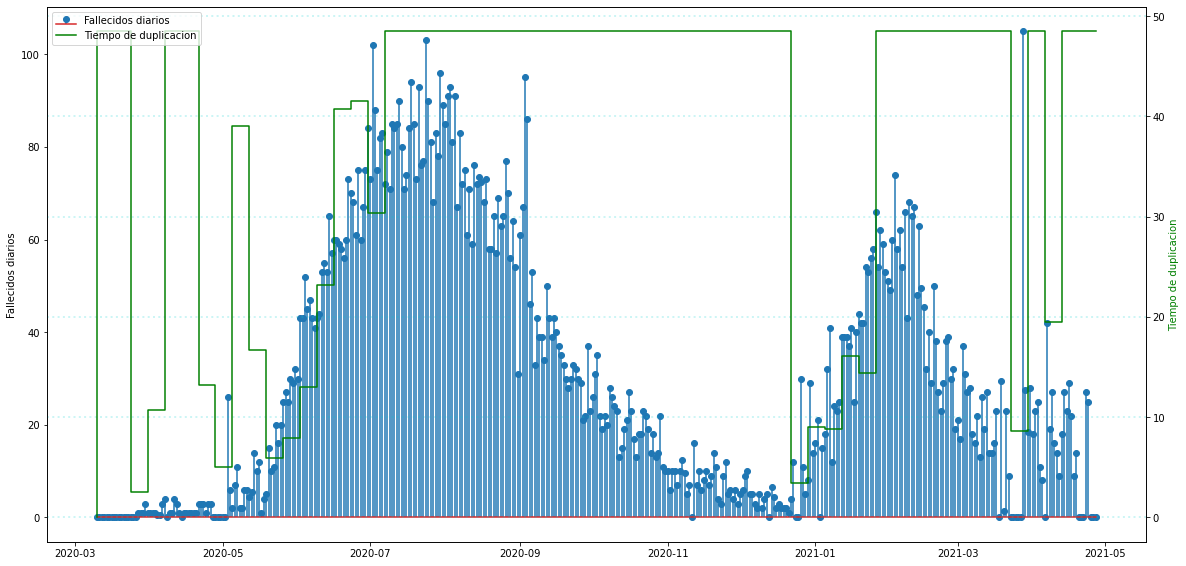

In [27]:
draw_doubling(data['death'], title='Fallecidos totales')
draw_doubling(daily_deaths, title='Fallecidos diarios')

###### Recuperados 

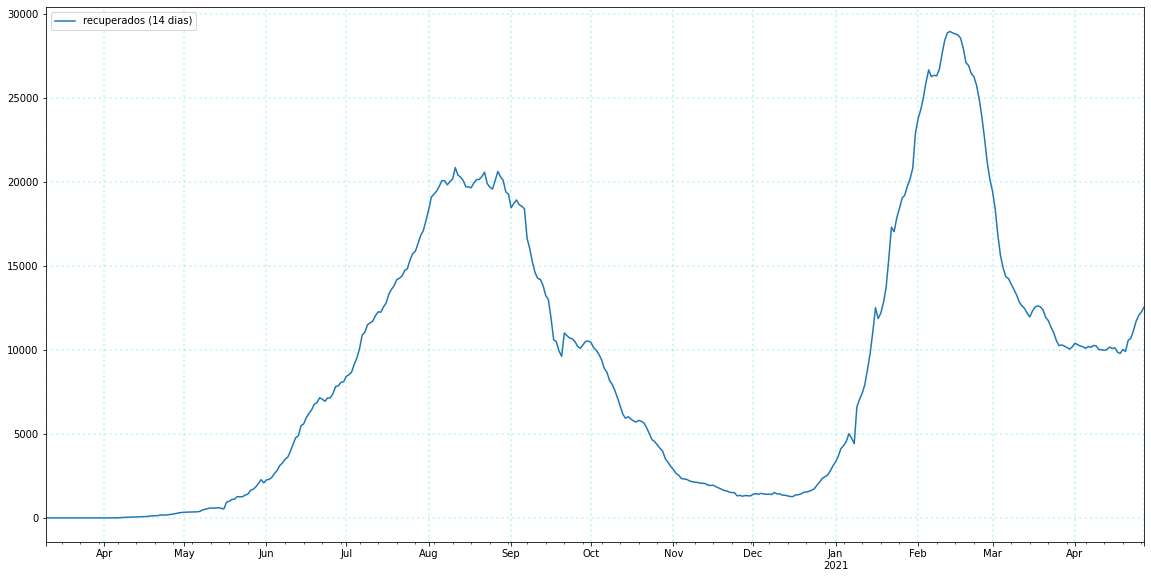

In [28]:
local_recovered = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'recovered']]
local_recovered.columns = local_recovered.columns.droplevel(1)
local_daily_recovered = local_recovered.diff()

ax = local_daily_recovered.rolling(window=14).sum().sum(axis=1).plot(
    label='recuperados (14 dias)'
)
stylize_ax(ax)

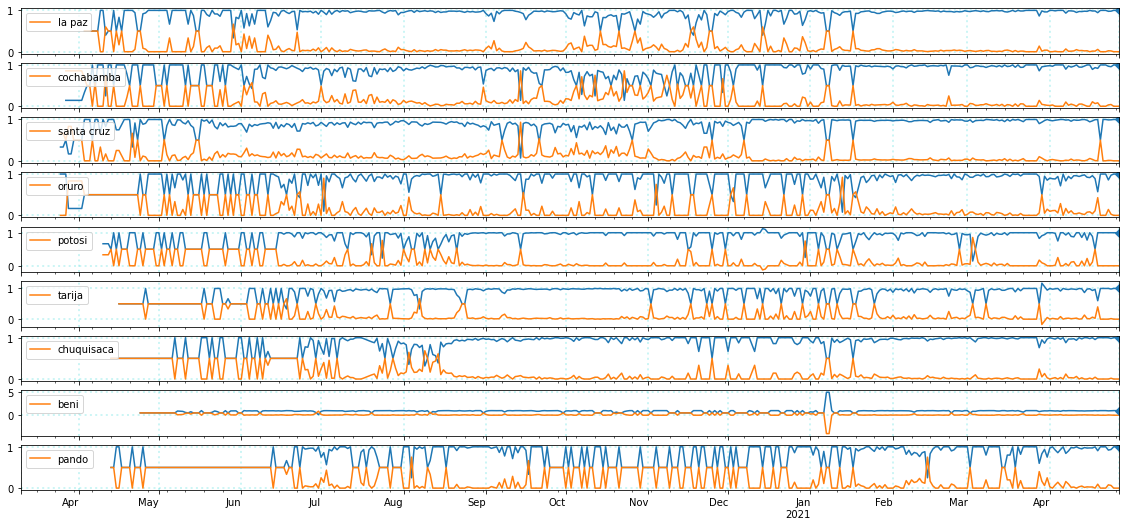

In [29]:
local_closed_cases = local_daily_recovered + local_deaths.diff()
local_closed_cases[local_closed_cases < 1] = 1

local_recovered_rate = local_daily_recovered / local_closed_cases
local_recovered_rate.rolling(window=7).mean()
local_recovered_rate[local_recovered_rate < .001] = .5

first, second = pyplot.rcParams['axes.prop_cycle'][:2]

axs = local_recovered_rate.plot(subplots=True, color=first['color'])
(1 - local_recovered_rate).plot(subplots=True, ax=axs.flatten(), color=second['color'])

stylize_subplots_axs(axs, annotate=False)

for idx, ax in enumerate(axs):
        if isinstance(ax, matplotlib.axes._subplots.Axes):
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            
            ax.legend(
                by_label.values(), 
                by_label.keys(), 
                loc='upper left'
            )

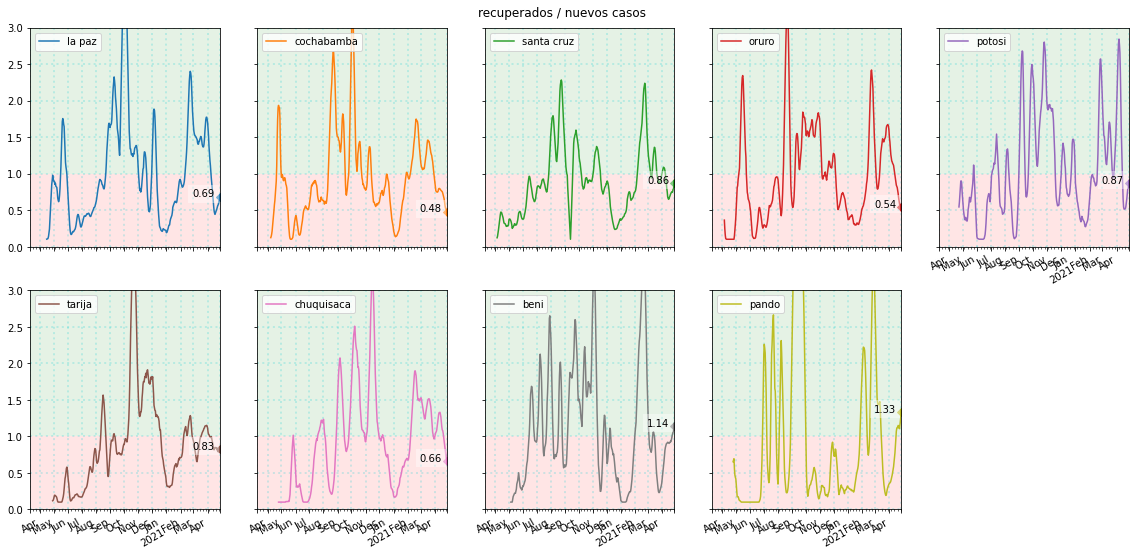

In [30]:
local_new_cases[local_new_cases < 1] = 1

local_recovered_to_new_cases = (
    local_daily_recovered.rolling(window=7).sum() / local_new_cases.rolling(window=7).sum()
)

local_recovered_to_new_cases[local_recovered_to_new_cases < 0.1] = .1
local_recovered_to_new_cases[local_recovered_to_new_cases > 3.5] = 3.5
local_recovered_to_new_cases = local_recovered_to_new_cases.rolling(window=7).mean()

axs = local_recovered_to_new_cases.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True,
)

for ax in axs.flatten():
    ax.axhspan(0, 1, facecolor='red', alpha=.1)
    ax.axhspan(1, 3, facecolor='green', alpha=.1)
    
    ax.set_ylim(0, 3)

at = axs[0][0].get_figure().suptitle('recuperados / nuevos casos', y=.91)
stylize_subplots_axs(axs)

##### Tests

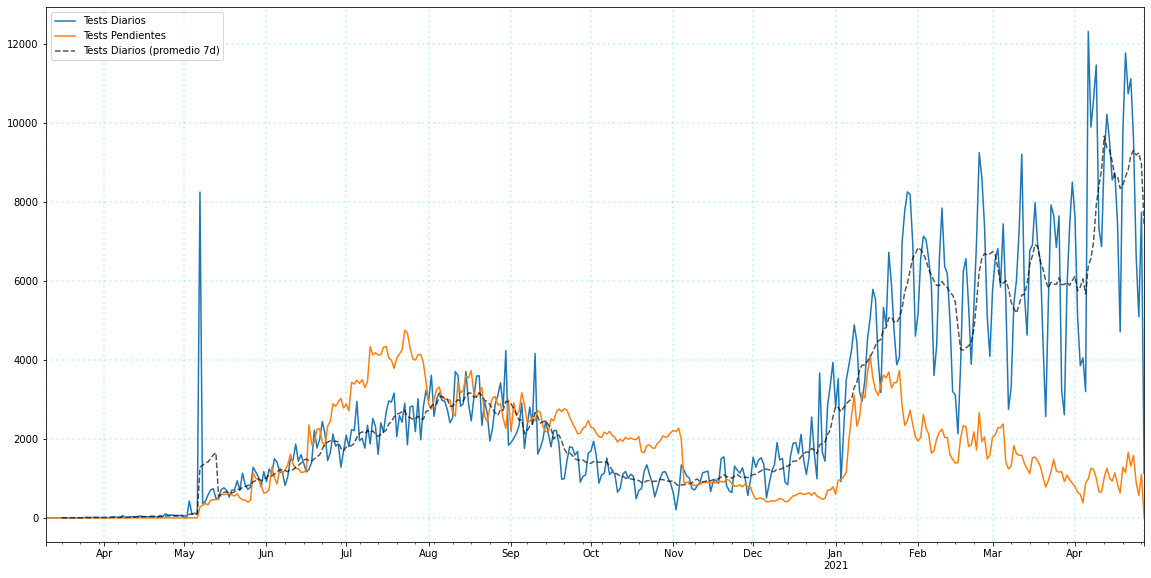

In [31]:
daily_tests = (data['cases'] + data['discarded']).diff()
daily_tests[np.isnan(daily_tests)] = 0
daily_tests[daily_tests < 1] = new_cases[daily_tests < 1]

daily_tests_adjusted = daily_tests * scale_to / sum(population.values())

pending_tests_df = pd.DataFrame([daily_tests, data['pending']])
pending_tests_df = pending_tests_df.T
pending_tests_df.columns = ['Tests Diarios', 'Tests Pendientes']
ax = pending_tests_df.plot()

pending_tests_df['Tests Diarios'].rolling(window=7).mean().plot(
    ax=ax, color='black', alpha=.66, linestyle='--', label='Tests Diarios (promedio 7d)'
)

stylize_ax(ax)

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a> + Recuperados   
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Los datos a partir del 2020-05-02 fueron recogidos y procesados por la revista <a href='https://muywaso.com/especial-de-datos-muy-waso-sobre-el-coronavirus-en-bolivia/'>muywaso.com</a>.

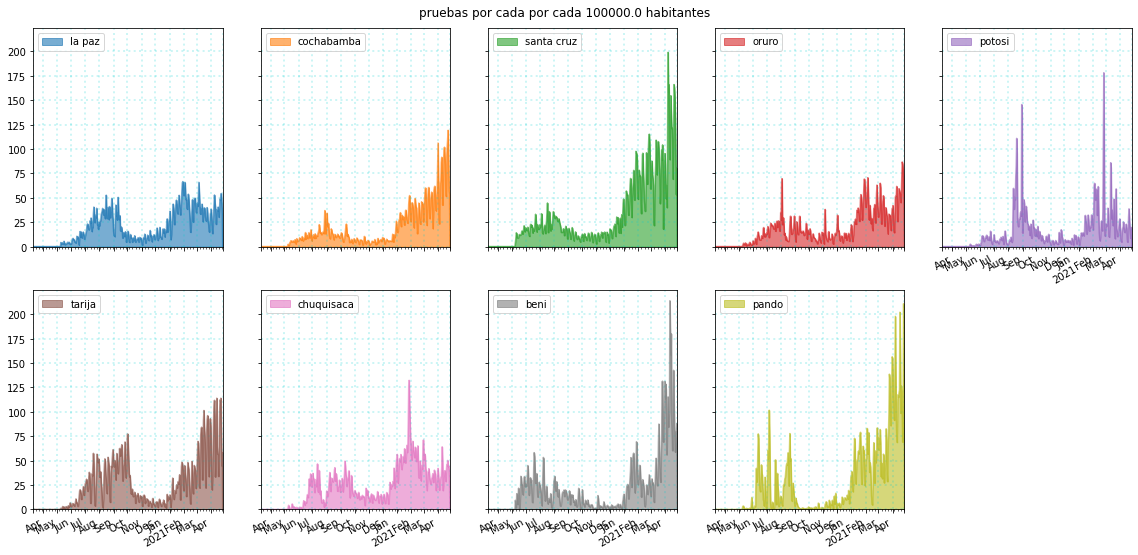

In [32]:
local_discarded = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'discarded']]
local_discarded.columns = local_discarded.columns.droplevel(1)

local_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']]
local_cases.columns = local_cases.columns.droplevel(1)

local_tests = local_discarded + local_cases
local_daily_tests = local_tests.diff()
local_daily_tests[local_daily_tests < local_new_cases] = local_new_cases[
    local_daily_tests < local_new_cases
]
local_daily_tests = local_daily_tests.rolling(window=2).mean()
local_daily_tests_adjusted = local_daily_tests * population_adjust

axs = local_daily_tests_adjusted.plot(
    kind='area',
    subplots=True,
    layout=(2,5), 
    sharey=True,
    alpha=.6
)

at = axs[0][0].get_figure().suptitle(
    'pruebas por cada por cada {0} habitantes'.format(scale_to), y=.91
)
stylize_subplots_axs(axs)

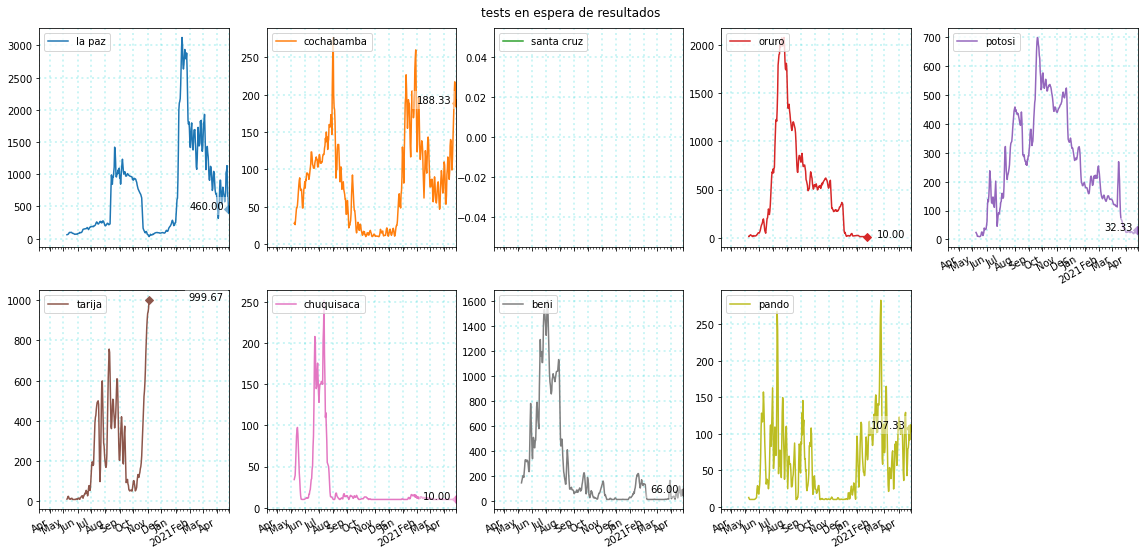

In [33]:
local_pending = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'pending']]
local_pending.columns = local_pending.columns.droplevel(1)
local_pending[local_pending < 10] = 10
local_pending = local_pending.rolling(window=3).mean()

axs = local_pending.plot(
    subplots=True, 
    layout=(2,5),
)

at = axs[0][0].get_figure().suptitle('tests en espera de resultados', y=.91)
stylize_subplots_axs(axs)

Cuan saturados estan los laboratorios?

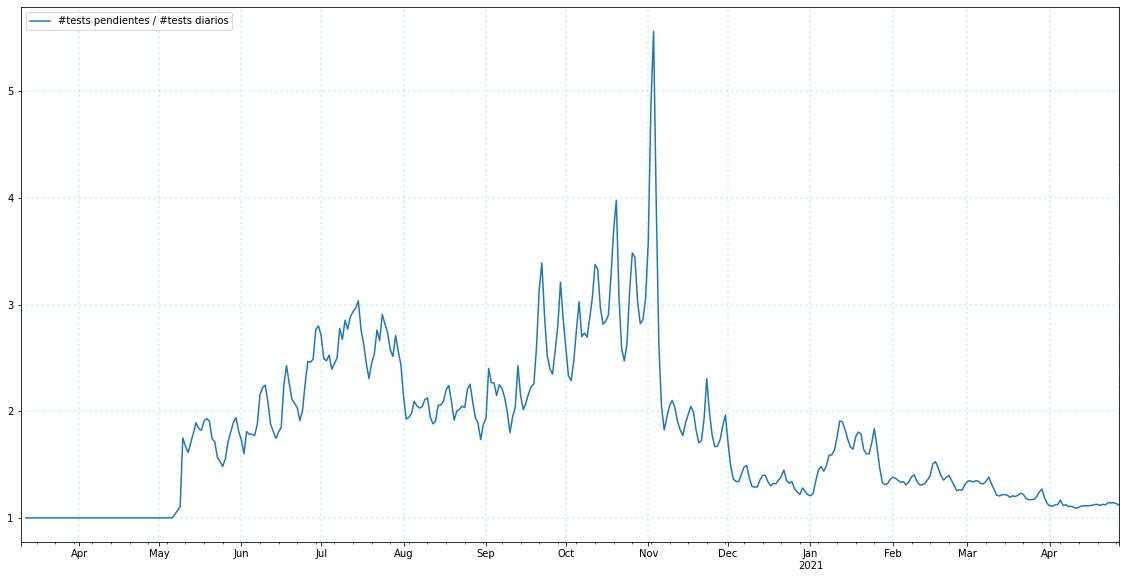

In [34]:
daily_tests_softened = pd.Series(daily_tests).rolling(window=3).sum()

pending_tests_by_capacity = (
    daily_tests_softened + data['pending'].rolling(window=3).sum()
) / daily_tests_softened
pending_tests_by_capacity[pending_tests_by_capacity < .1] = .1

ax = pending_tests_by_capacity.plot(label='#tests pendientes / #tests diarios')
stylize_ax(ax)

* Esto esta cerca de estimar la demora de los resultados de las pruebas

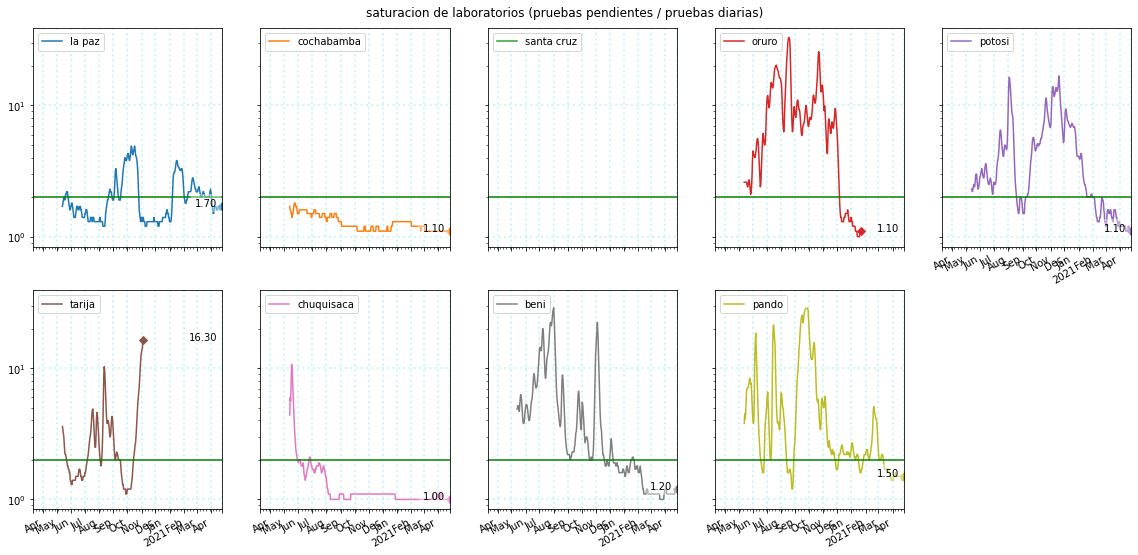

In [35]:
local_daily_tests_softened = local_daily_tests.rolling(window=5).sum()
local_pending_tests_by_capacity = (
    local_daily_tests_softened + local_pending.rolling(window=5).sum()
) / local_daily_tests_softened
local_pending_tests_by_capacity[local_pending_tests_by_capacity > 30] = 30

axs = fast_smooth_df(local_pending_tests_by_capacity).round(1).plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True,
    logy=True
)

at = axs[0][0].get_figure().suptitle('saturacion de laboratorios (pruebas pendientes / pruebas diarias)', y=.91)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        ax.axhline(2., color='green')

Cuantos tests se necesitan para encontar un caso positivo?

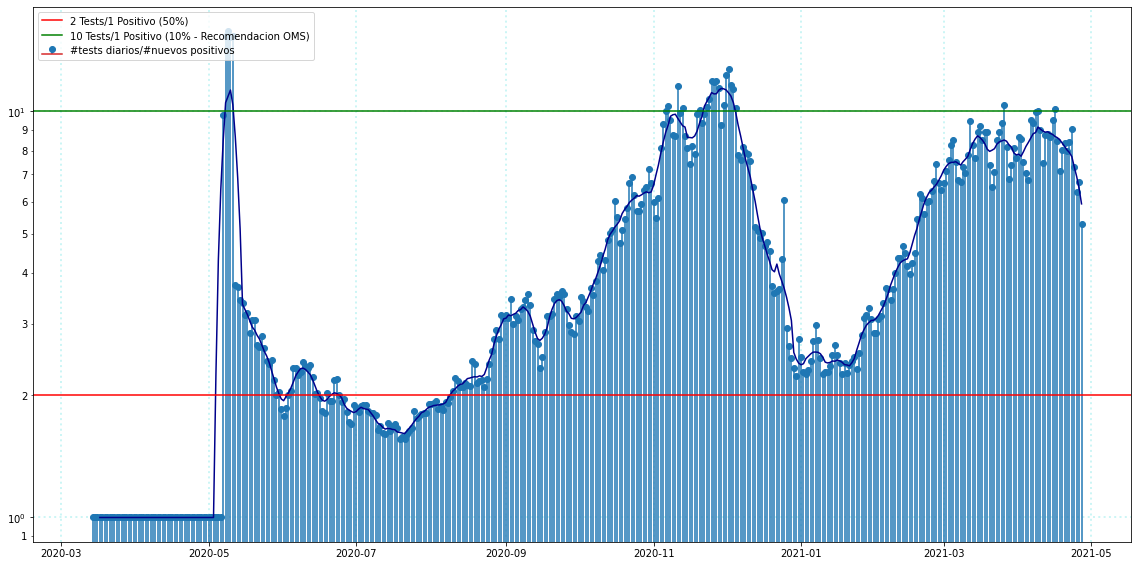

In [36]:
test_case_ratio = daily_tests.rolling(window=5).sum() / new_cases.rolling(window=5).sum()
# test_case_ratio[test_case_ratio == 1] = 0

ax = plot_moving_averaged(
    x, test_case_ratio, 
    label='#tests diarios/#nuevos positivos',
    window_size = 7
)
ax.axhline(2., label='2 Tests/1 Positivo (50%)', color='red')
ax.axhline(10., label='10 Tests/1 Positivo (10% - Recomendacion OMS)', color='green')

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')

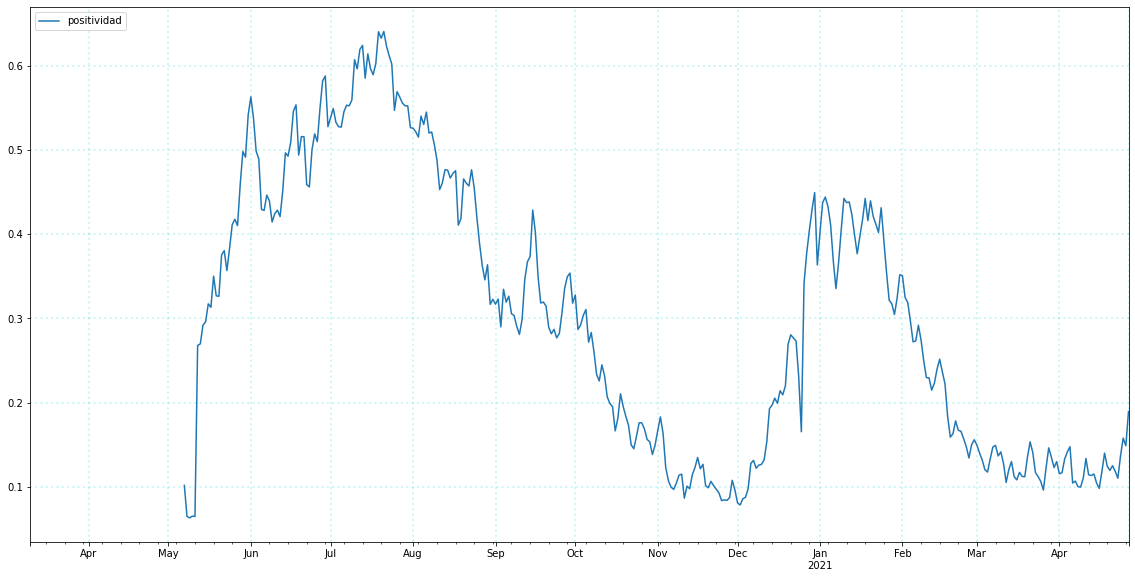

In [37]:
ax = (1 / test_case_ratio).where((1 / test_case_ratio) < .99, np.nan).plot(label='positividad')
stylize_ax(ax)

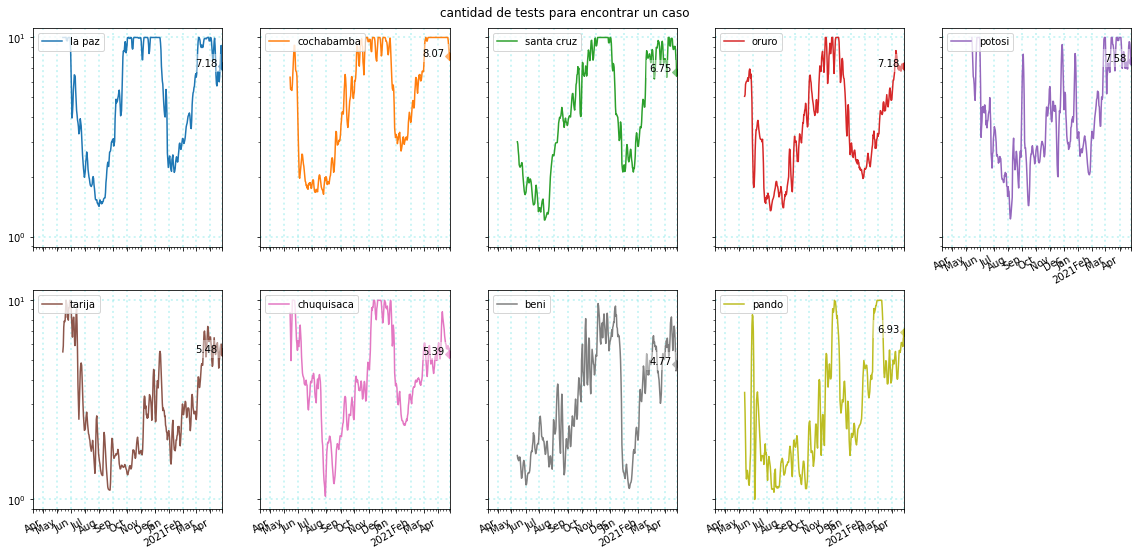

In [38]:
def get_ratio(daily_tests):
    test_case_ratio = daily_tests.rolling(window=5).sum() / local_new_cases.rolling(window=5).sum()
    test_case_ratio[test_case_ratio < 1] = 1
    test_case_ratio[test_case_ratio > 10] = 10
    
    return test_case_ratio.rolling(window=3).mean()

local_daily_tests = (local_tests).diff()
local_daily_tests[local_daily_tests < local_new_cases] = local_new_cases[
    local_daily_tests < local_new_cases
]

local_test_case_ratio = get_ratio(local_daily_tests)
axs = local_test_case_ratio.plot(subplots=True, layout=(2,5), sharey=True, logy=True)

at = axs[0][0].get_figure().suptitle('cantidad de tests para encontrar un caso', y=.91)
stylize_subplots_axs(axs)

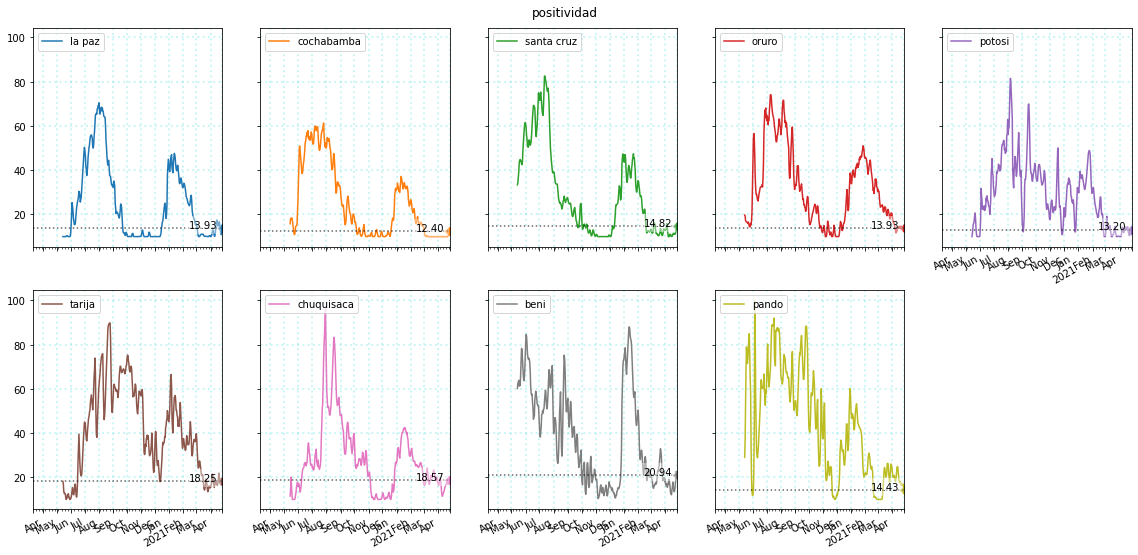

In [39]:
axs = (100 / local_test_case_ratio).plot(
    subplots=True, layout=(2,5), sharey=True
)

at = axs[0][0].get_figure().suptitle('positividad', y=.91)
stylize_subplots_axs(axs, xline=True)

razon de reproduccion vs razon de crecimiento del sistema de diagnostico (?)

In [40]:
testing_growth_rate, tgr_min, tgr_max = estimate_rt(daily_tests, window_size=7, smooth_seasons=False)
testing_growth_rate[testing_growth_rate < 0.01] = np.nan
testing_growth_rate = pd.Series(testing_growth_rate, index=x[:-6])

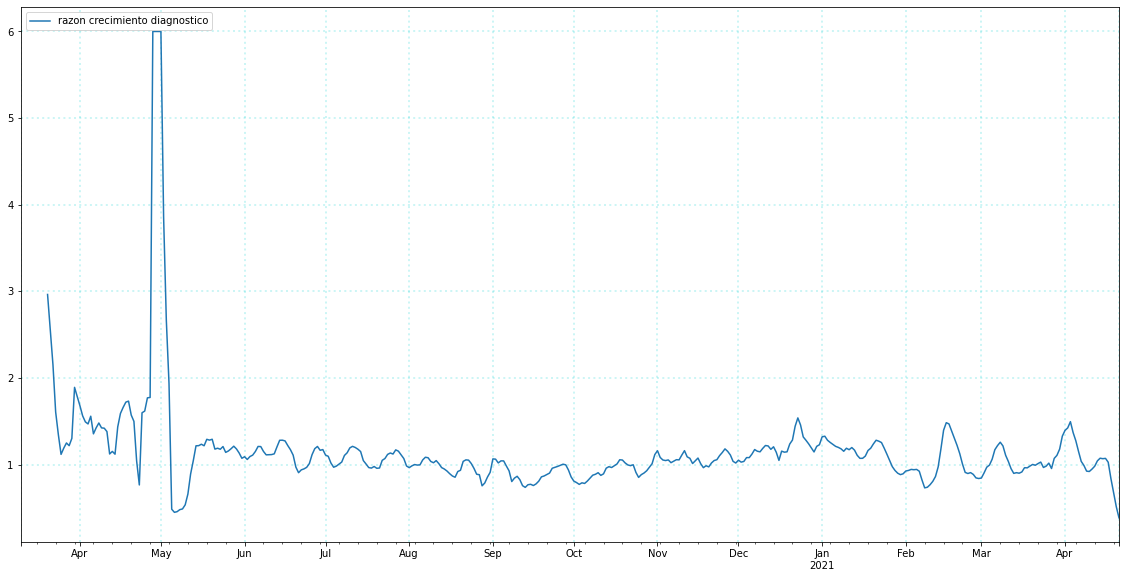

In [41]:
ax = testing_growth_rate.plot(label='razon crecimiento diagnostico')

stylize_ax(ax)

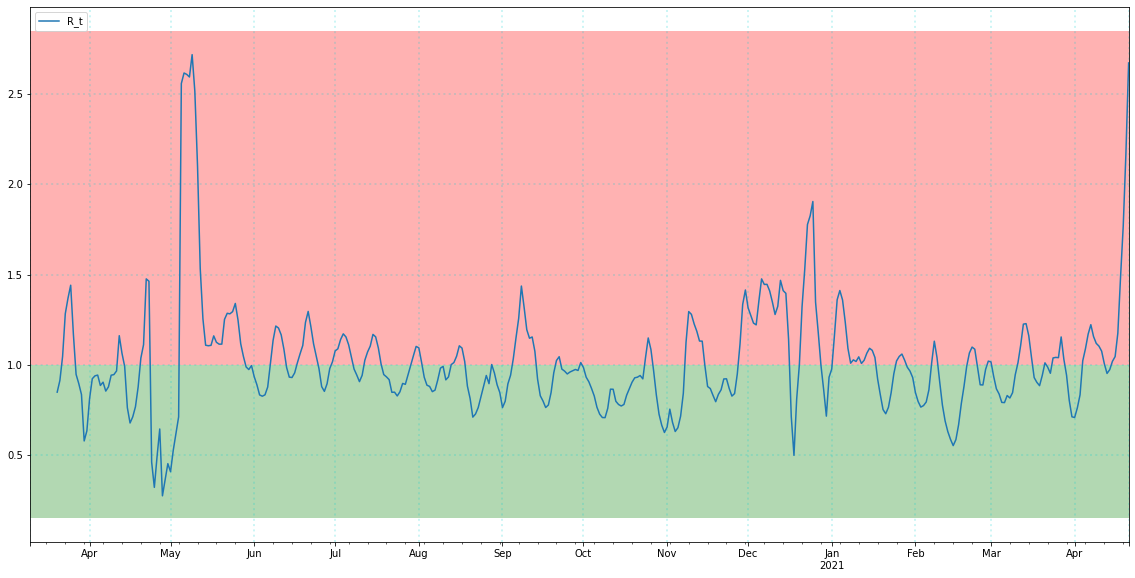

In [42]:
ax = (r_ts.T / testing_growth_rate).T.plot(label='R_t / razon crecimiento diagnostico')
ax.axhspan(ax.get_ylim()[0], 1, facecolor='green', alpha=.3)
ax.axhspan(1, ax.get_ylim()[1], facecolor='red', alpha=.3)

stylize_ax(ax)

In [43]:
local_tgr = pd.DataFrame(index=x)
do_pad = lambda arr:  np.pad(arr, (0, 6), 'constant', constant_values=(np.nan,))

for column in local_daily_tests.columns:
    ltgr, _, _ = estimate_rt(local_daily_tests[column].fillna(1), window_size=7, smooth_seasons=False)
    local_tgr[column] = do_pad(ltgr)

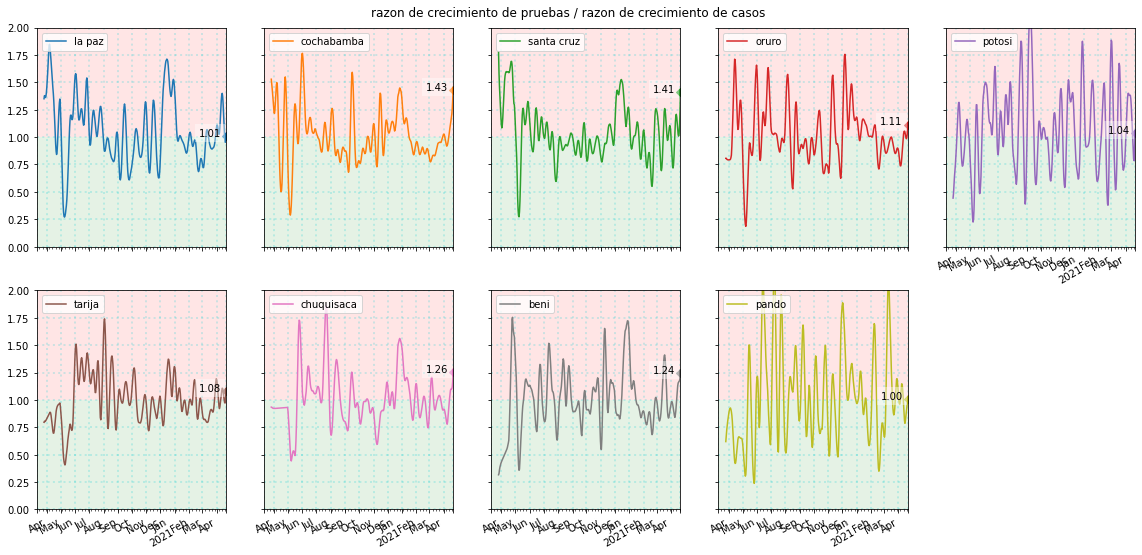

In [44]:
local_tgr2rts = local_rts / local_tgr
local_tgr2rts[local_tgr2rts > 2.] = 2.

axs = fast_smooth_df(local_tgr2rts.rolling(window=7).mean(), .4).plot(
    subplots=True, layout=(2, 5), sharey=True
)

for ax in axs.flatten():
    ax.axhspan(0, 1, facecolor='green', alpha=.1)
    ax.axhspan(1, 2, facecolor='red', alpha=.1)
    
    ax.set_ylim(0, 2)

at = axs[0][0].get_figure().suptitle('razon de crecimiento de pruebas / razon de crecimiento de casos', y=.91)
stylize_subplots_axs(axs)

###### Seguimiento de contactos (archivado)

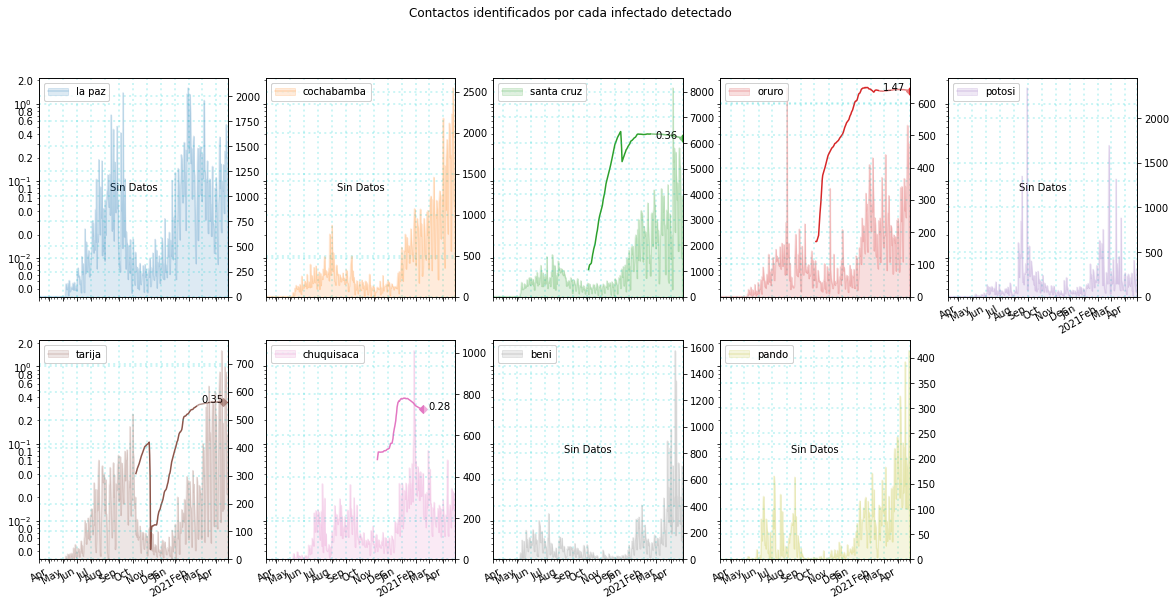

In [45]:
traced_contacts = pd.read_csv('./data/contact.tracing.csv')
traced_contacts = traced_contacts.iloc[:, 1:]
traced_contacts.columns = [do_process_label(_) for _ in traced_contacts.columns]

traced_shift_by = len(local_cases) - len(traced_contacts)
traced_contacts = traced_contacts.rolling(window=3).mean()
traced_contacts = traced_contacts.append(pd.DataFrame(
    index=range(traced_shift_by)
), sort=True)
traced_contacts = traced_contacts.shift(traced_shift_by).reset_index(drop=True)
traced_contacts = traced_contacts.set_index(x[-len(traced_contacts):])

selected_local_cases = local_cases.loc[traced_contacts.first_valid_index():][traced_contacts.columns]

contacts_by_case = traced_contacts / selected_local_cases

for column in local_daily_tests.columns:
    if column and column not in contacts_by_case.columns:
        holder = np.zeros(len(contacts_by_case), dtype=float)
        holder.fill(np.nan)
        
        contacts_by_case[column] = holder
        
contacts_by_case = contacts_by_case[local_daily_tests.columns]
contacts_by_case[contacts_by_case > 30] = 30

axs = contacts_by_case.plot(
    title='Contactos identificados por cada infectado detectado',
    subplots=True,
    layout=(2,5),
    sharey=True,
    logy=True
)
axs_2 = local_daily_tests.plot(
    kind='area', 
    ax=[ax.twinx() for ax in axs.flatten()[:-1]], 
    subplots=True,
    alpha=0.15
)
stylize_subplots_axs(axs_2, annotate=False)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        if not ax.get_lines():
            continue
            
        label = ax.get_lines()[0].get_label()
        if not contacts_by_case[label].any():
            ax.text(
                0.5, 0.5, 
                'Sin Datos', 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes
            )
        
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        for idx, tick in enumerate(ax.yaxis.get_minor_ticks()):
            if idx % 2 == 0:
                continue
                
            tick.label1.set_visible(False)

* La cantidad de contactos es mayor en Tarija, el sedes reporta los contactos activos (serie con adiciones y substracciones), el total solo se puede estimar.   
* No se encontro datos de otros departamentos.

Es dificil escoger un minimo aqui, depende mucho de la definicion de contacto, la velocidad de reaccion (la mayoria de los contagios se dan <a href=''>en el periodo presintomatico o en los primeros dias</a>), la calidad de las entrevistas y el seguimiento.   
<a href='https://www.medrxiv.org/content/10.1101/2020.02.14.20023036v1'>Esta investigacion</a> recomienda ~ 30.

###### Vacunas

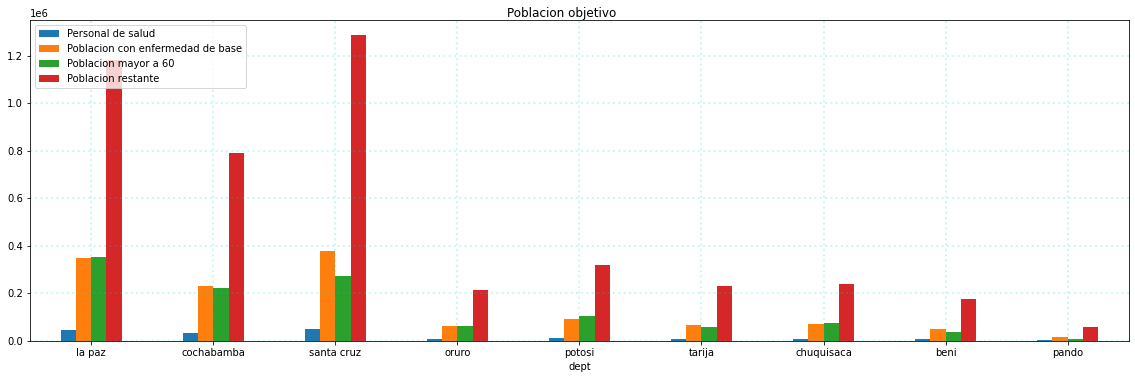

In [46]:
vaccine_target_population = pd.read_csv('./data/vaccine.target.population.csv')
vaccine_target_population['dept'] = vaccine_target_population['dept'].str.lower()
vaccine_target_population = vaccine_target_population.set_index('dept').T

vaccine_target_population = vaccine_target_population[
    local_data.columns.get_level_values(0).unique()
]

ax = vaccine_target_population.T.plot(kind='bar', figsize=(50/2.54, 15/2.54))
al = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.get_figure().suptitle('Poblacion objetivo', y=.91)
stylize_ax(ax)

In [47]:
vaccine_target_population.sum() / pd.DataFrame.from_dict([population])

beni  chuquisaca  cochabamba    la paz     oruro     pando    potosi  \
0  0.558931    0.614929    0.627771  0.658959  0.627617  0.562547  0.589046   

   santa cruz    tarija  
0    0.589935  0.627552

In [48]:
vaccinations_df = pd.read_csv(
    remote_path('processed/bolivia/vaccinations.csv'), 
    header=[0, 1], 
    index_col=[0]
)
vaccinations_df.index = pd.to_datetime(vaccinations_df.index)

vaccinations_df_columns = vaccinations_df.columns.map(lambda _: [__.lower() for __ in _])
vaccinations_df.columns = pd.MultiIndex.from_tuples([*vaccinations_df_columns.values])

vaccinations_df.head(1)

la paz         cochabamba         santa cruz           oruro  \
           primera segunda    primera segunda    primera segunda primera   
Fecha                                                                      
2021-02-02      12       0        278       0        647       0      26   

                    potosi          tarija         chuquisaca            beni  \
           segunda primera segunda primera segunda    primera segunda primera   
Fecha                                                                           
2021-02-02       0     138       0      90       0        122       0       6   

                     pando          
           segunda primera segunda  
Fecha                               
2021-02-02       0     270       0

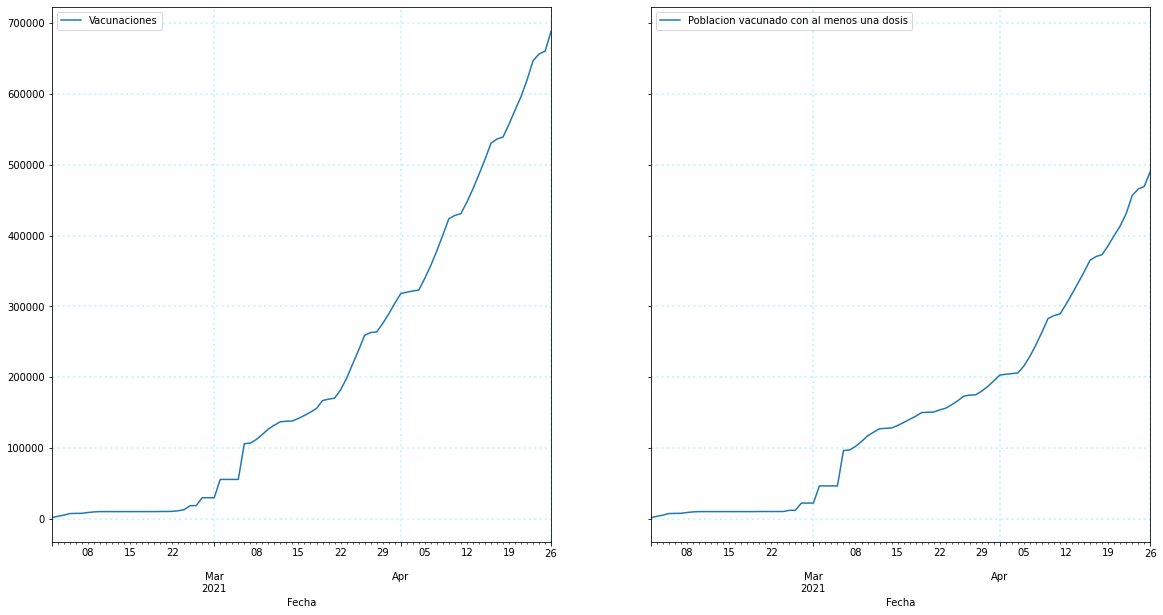

In [49]:
vaccinations_total_doses = vaccinations_df.groupby(level=1, axis=1, sort=False).sum()
fig, axs = pyplot.subplots(ncols=2, nrows=1, sharey=True)

vaccinations_total_doses.sum(axis=1).plot(label='Vacunaciones', ax=axs[0])
vaccinations_total_doses['primera'].plot(label='Poblacion vacunado con al menos una dosis', ax=axs[1])

stylize_ax(axs)

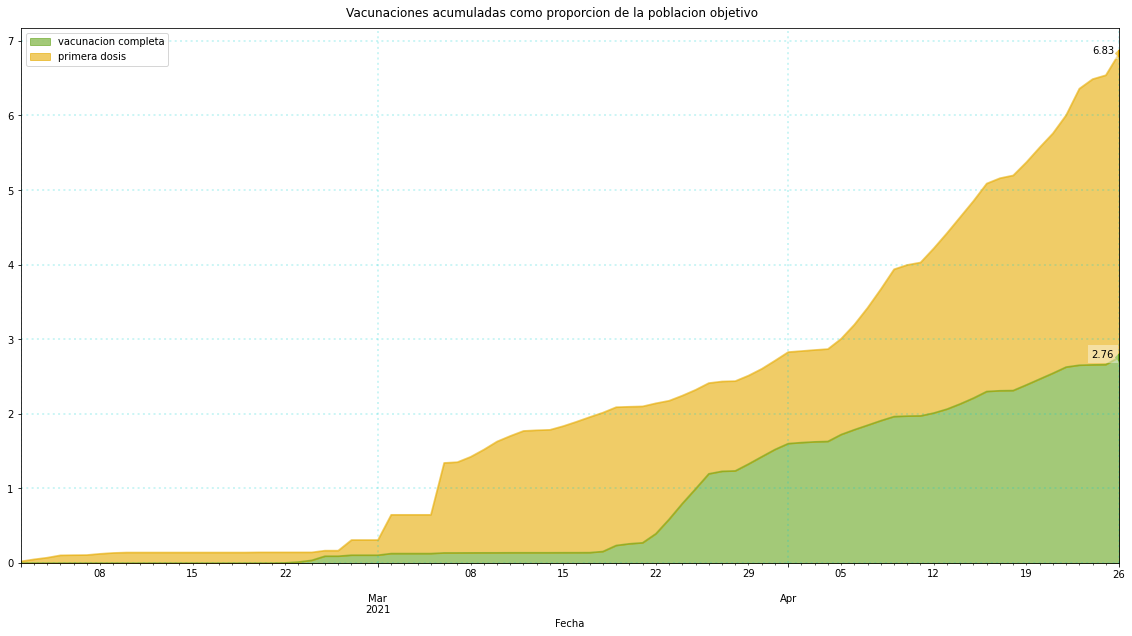

In [50]:
vaccinations_total_doses['primera'] = (
    vaccinations_total_doses['primera'] - vaccinations_total_doses['segunda']
)

vaccinations_total_doses = 100 * vaccinations_total_doses / vaccine_target_population.sum().sum()

vaccinations_total_doses = vaccinations_total_doses.rename({
    'segunda': 'vacunacion completa',
    'primera': 'primera dosis'
}, axis=1)

ax = vaccinations_total_doses[vaccinations_total_doses.columns[::-1]].plot(
    kind='area', alpha=.6, color=state_colors[:2][::-1]
)

at = ax.get_figure().suptitle(
    'Vacunaciones acumuladas como proporcion de la poblacion objetivo', y=.91
)
stylize_subplots_axs([[ax]])

In [51]:
def vaccinations_local_doses_scaled_plot(self, layout=None, **kwargs):
    if 'ax' in kwargs:
        axs = kwargs['ax']
        del kwargs['ax']
        
    elif layout:
        nrows, ncols = layout
        fig, axs = pyplot.subplots(
            ncols=ncols, nrows=nrows, sharex=True, sharey=True
        )
        
    else:
        fig, axs = pyplot.subplots(nrows=len(self.columns.levels[0]))
        
    plot_to_axs = axs.flatten()
    
    if 'subplots' in kwargs:
        del kwargs['subplots']

    for idx,(dept, dept_vaccinations) in enumerate(
        self.groupby(level=0, axis=1, sort=False)
    ):
        dept_vaccinations = dept_vaccinations.droplevel(0, axis=1).rename({
            'segunda': 'completa',
            'primera': 'primera dosis'
        }, axis=1)
        ax = dept_vaccinations[dept_vaccinations.columns[::-1]].plot(
            kind='area', ax=plot_to_axs[idx], alpha=.6, color=state_colors[:2][::-1]
        )
        ax.tick_params(labelsize=8.)
        ax.autoscale(tight=True)
        ax.legend(title='', framealpha=.5)
        
    al = ax.set_ylim(
        0, vaccinations_local_doses_scaled.groupby(level=0, axis=1).sum().max().max() * 1.05
    )
        
    return axs

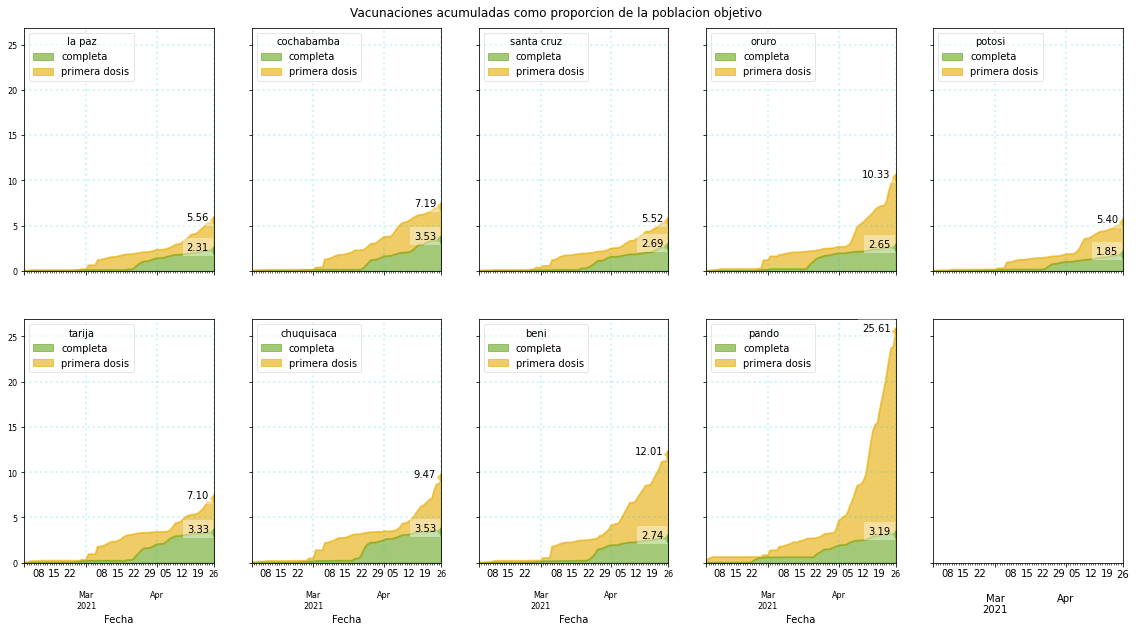

In [52]:
vaccinations_local_doses = vaccinations_df.copy()
vaccinations_local_doses = vaccinations_local_doses.swaplevel(1, 0, 1).copy()

vaccinations_local_doses['primera'] = (
    vaccinations_local_doses['primera'] - vaccinations_local_doses['segunda']
)

vaccinations_local_doses_scaled = vaccinations_local_doses.copy()
vaccinations_local_doses_scaled['primera'] = (
    100 * vaccinations_local_doses_scaled['primera'] / vaccine_target_population.sum()
).round(2)

vaccinations_local_doses_scaled['segunda'] = (
    100 * vaccinations_local_doses_scaled['segunda'] / vaccine_target_population.sum()
).round(2)

vaccinations_local_doses_scaled = vaccinations_local_doses_scaled.swaplevel(1, 0, 1)
vaccinations_local_doses_scaled.plot = MethodType(
    vaccinations_local_doses_scaled_plot, vaccinations_local_doses_scaled
)

axs = vaccinations_local_doses_scaled.plot(layout=(2, 5))
axs = axs.flatten()

vacunations_depts = vaccinations_local_doses_scaled.columns.get_level_values(0).unique()
[axs[idx].legend(title=vacunations_depts[idx]) for idx in range(len(axs) - 1)]

at = axs[0].get_figure().suptitle(
    'Vacunaciones acumuladas como proporcion de la poblacion objetivo', y=.91
)

stylize_subplots_axs(axs, framealpha=.5)
base_ticks = axs[0].xaxis

###### Comparativo I

In [53]:
def plot_quivered(data_x, data_y):
    ax = plot(data_x, data_y)

    u = data_x.diff()
    v = data_y.diff()

    pos_x = data_x[:-1] + u/2
    pos_y = data_y[:-1] + v/2

    norm = np.sqrt(u**2 + v**2) 

    aq = ax.quiver(
        pos_x, pos_y, 
        u / norm, v / norm,
        dates.date2num(data_x.index),
        cmap='plasma_r',
        angles='xy', 
        headwidth=5,
        zorder=5, 
        pivot='mid'
    )

#     ax.set_xlim((0, max(data['active_cases'])))
#     ax.set_ylim(0, max(2.5, max(r_ts[2:]) * 1.05))

    stylize_ax(ax)

    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)

    fig = ax.get_figure()
    fig.add_axes(cax)

    cb = fig.colorbar(aq, cax=cax, orientation="horizontal")
    tl = cb.ax.set_xticklabels([
        '{}'.format(dates.num2date(_))[:10] for _ in cb.get_ticks()
    ])
    
    return ax

No handles with labels found to put in legend.


Text(0.5, 1.0, 'casos activos por fallecidos diarios (reportes diarios)')

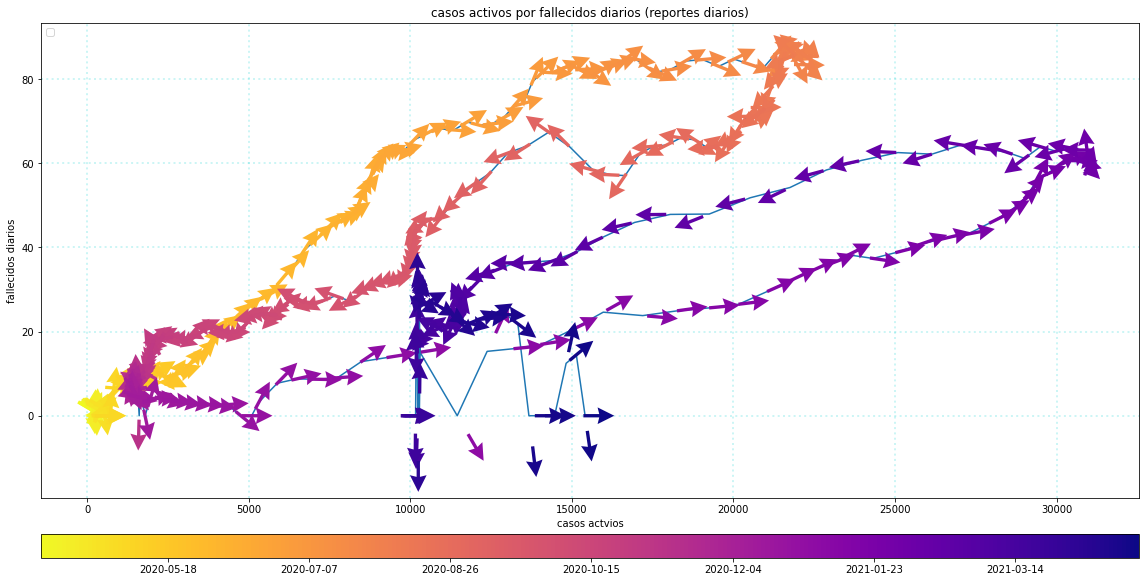

In [54]:
data_x = local_data.loc[:,pd.IndexSlice[:,'death']].sum(axis=1).diff()
data_y = data['active_cases'].dropna()

data_x = fast_smoothing(data_x['2020-04-02':], .15)
data_y = fast_smoothing(data_y['2020-04-02':], .15)

data_x, data_y = data_y, data_x

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('casos actvios')
ax.set_ylabel('fallecidos diarios')

ax.set_title('casos activos por fallecidos diarios (reportes diarios)')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'casos recuperados por quincena por fallecidos diarios (reportes diarios)')

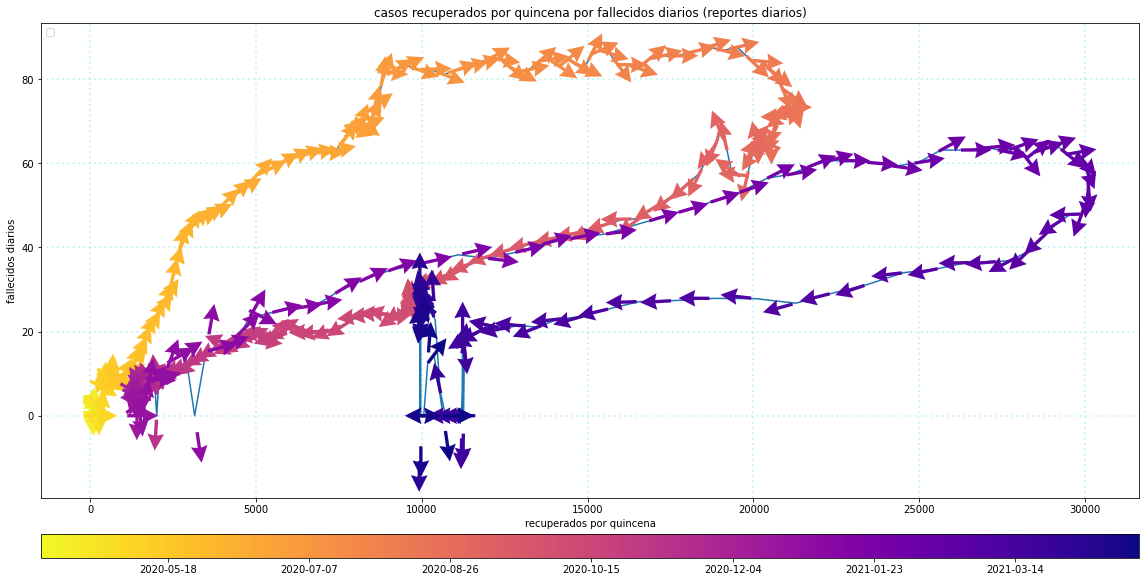

In [55]:
data_x = local_data.loc[:,pd.IndexSlice[:,'death']].sum(axis=1).diff()
data_y = data['recovered'].diff().where(data['recovered'].diff() > 0, 0).rolling(window=14).sum()

data_x = fast_smoothing(data_x['2020-04-02':], .15)
data_y = fast_smoothing(data_y['2020-04-02':], .15)

data_x, data_y = data_y, data_x

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('recuperados por quincena')
ax.set_ylabel('fallecidos diarios')

ax.set_title('casos recuperados por quincena por fallecidos diarios (reportes diarios)')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'casos activos por razon de reproduccion (R_t)')

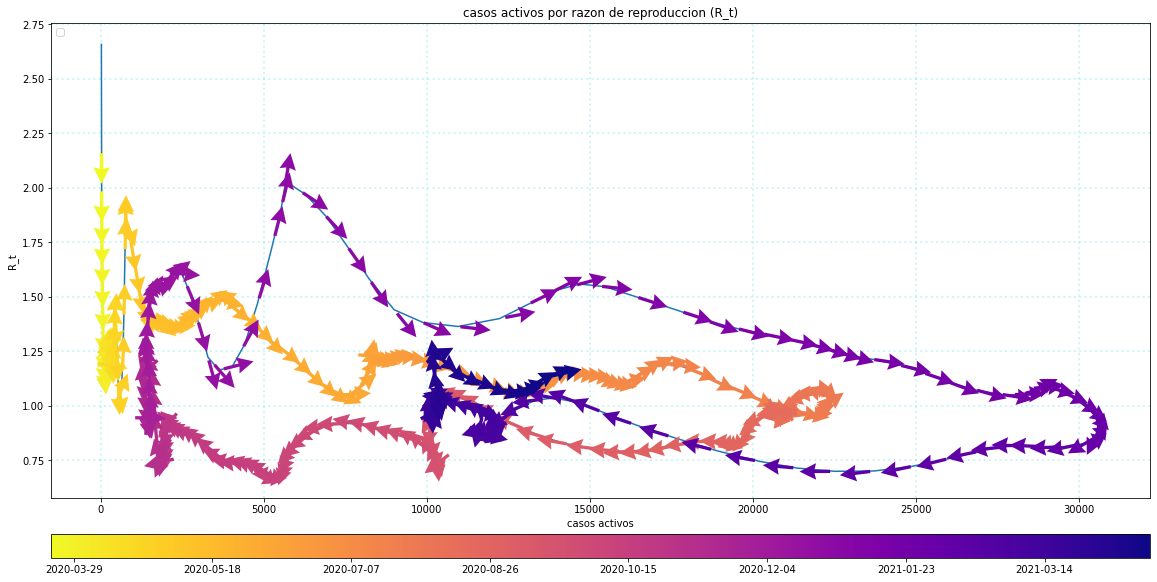

In [56]:
data_x = data['active_cases'][:-6]
data_y = r_ts['R_t']

data_y = fast_smoothing(data_y.dropna())
data_x = fast_smoothing(data_x.dropna())
data_x = data_x[data_y.index[0]:]

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('casos activos')
ax.set_ylabel('R_t')

ax.set_title('casos activos por razon de reproduccion (R_t)')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'casos recuperados por razon de crecimiento de fallecimientos')

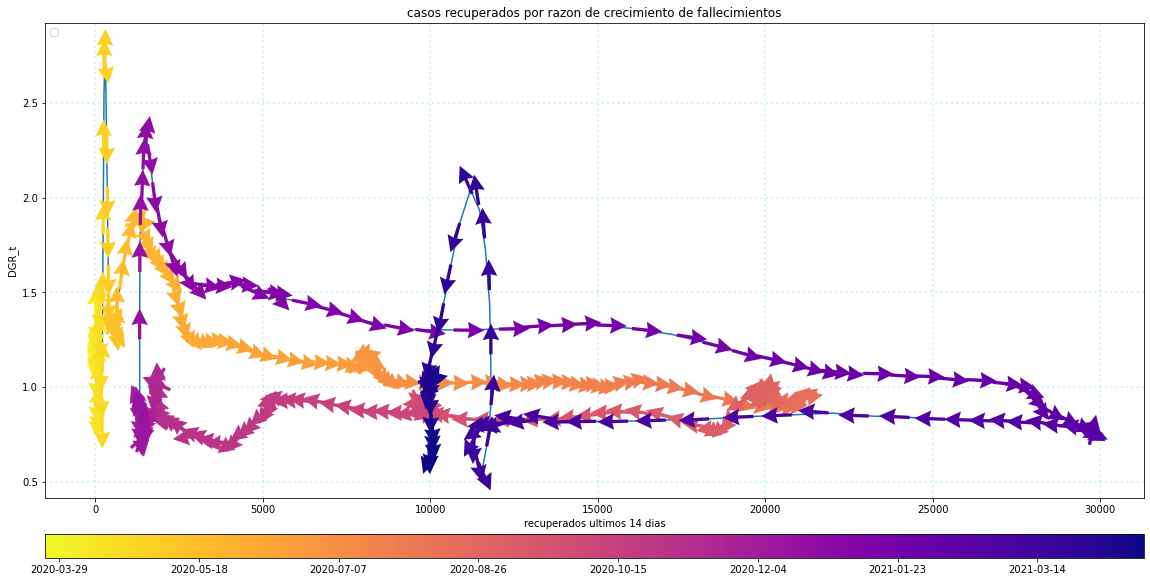

In [57]:
dgr_ts, dgr_ts_min, dgr_ts_max = estimate_rt(daily_deaths, window_size=7, smooth_seasons=False)
dgr_ts[dgr_ts < 0.01] = np.nan

data_x = data['recovered'].diff().where(data['recovered'].diff() > 0, 0).rolling(window=14).sum()[:-6]
# data_x = data['active_cases'][:-6]

data_y = pd.Series(dgr_ts, index=data_x.index)

data_x = fast_smoothing(data_x.dropna()[:])
data_y = fast_smoothing(data_y.dropna()[3:])

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('recuperados ultimos 14 dias')
ax.set_ylabel('DGR_t')

ax.set_title('casos recuperados por razon de crecimiento de fallecimientos')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'casos activos por positividad')

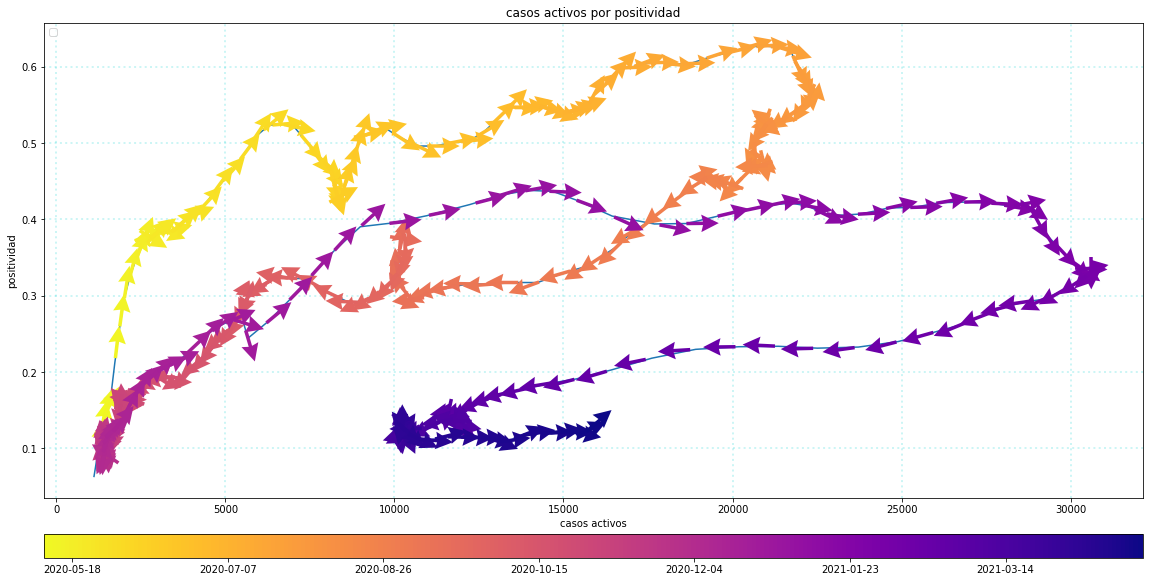

In [58]:
data_x = data['active_cases'].dropna()
data_y = new_cases.rolling(window=5).sum() / daily_tests.rolling(window=5).sum()
data_y = data_y.loc[data_x.first_valid_index():]

data_x = fast_smoothing(data_x['2020-05-08':])
data_y = fast_smoothing(data_y['2020-05-08':])

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('casos activos')
ax.set_ylabel('positividad')

ax.set_title('casos activos por positividad')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'fallecidos diarios (reportes diarios) por positivdad')

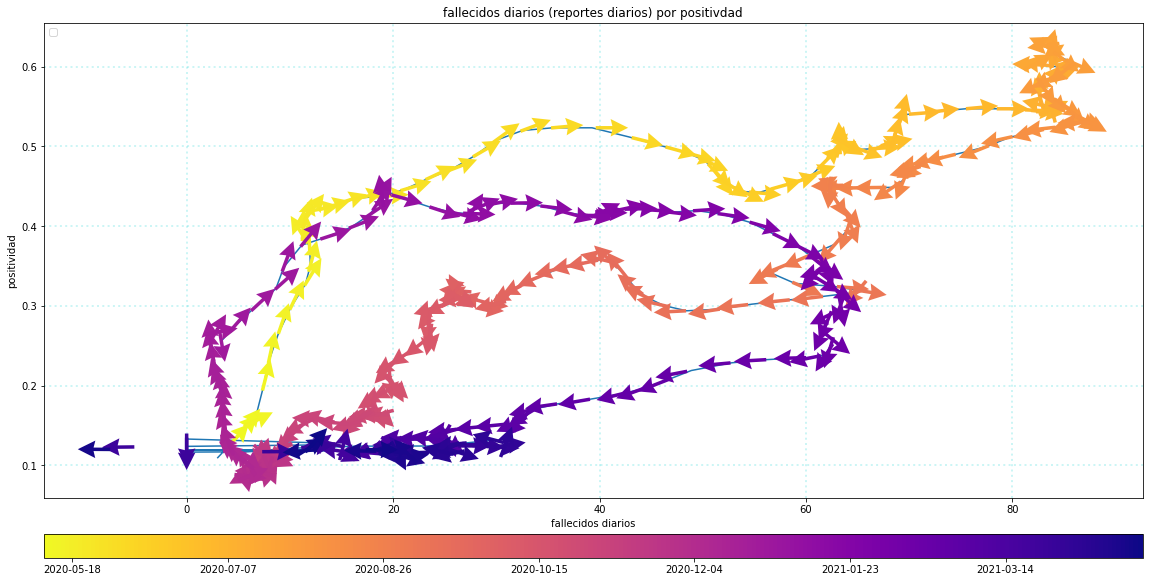

In [59]:
data_x = local_data.loc[:,pd.IndexSlice[:,'death']].sum(axis=1).diff()
data_y = new_cases.rolling(window=5).sum() / daily_tests.rolling(window=5).sum()
data_y = data_y.loc[data_x.first_valid_index():]

# data_x[data_x > 1000] = 100 # fix scz
data_x = data_x.rolling(window=3).mean()

data_x = fast_smoothing(data_x['2020-05-08':], .15)
data_y = fast_smoothing(data_y['2020-05-08':], .15)

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('fallecidos diarios')
ax.set_ylabel('positividad')

ax.set_title('fallecidos diarios (reportes diarios) por positivdad')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'fallecidos diarios (reportes diarios) por razon de reproduccion (R_t)')

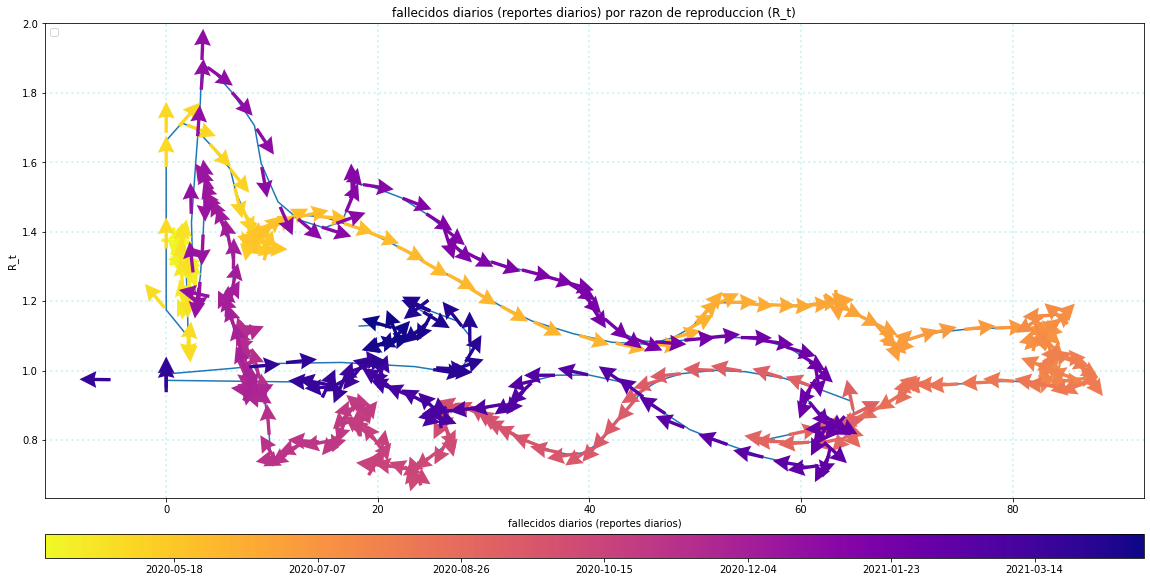

In [60]:
data_x = local_data.loc[:,pd.IndexSlice[:,'death']].sum(axis=1).diff()[:-6]
# data_y = new_cases.rolling(window=5).sum() / daily_tests.rolling(window=5).sum()
# data_y = data_y.loc[data_x.first_valid_index():]
data_y = r_ts['R_t']


# data_x[data_x > 1000] = 100 # fix scz
data_x = data_x.rolling(window=3).mean()

data_x = fast_smoothing(data_x['2020-04-02':], .15)
data_y = fast_smoothing(data_y['2020-04-02':], .15)

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('fallecidos diarios (reportes diarios)')
ax.set_ylabel('R_t')

ax.set_title('fallecidos diarios (reportes diarios) por razon de reproduccion (R_t)')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'fallecidos diarios (reportes diarios) por razon de crecimiento de fallecimientos')

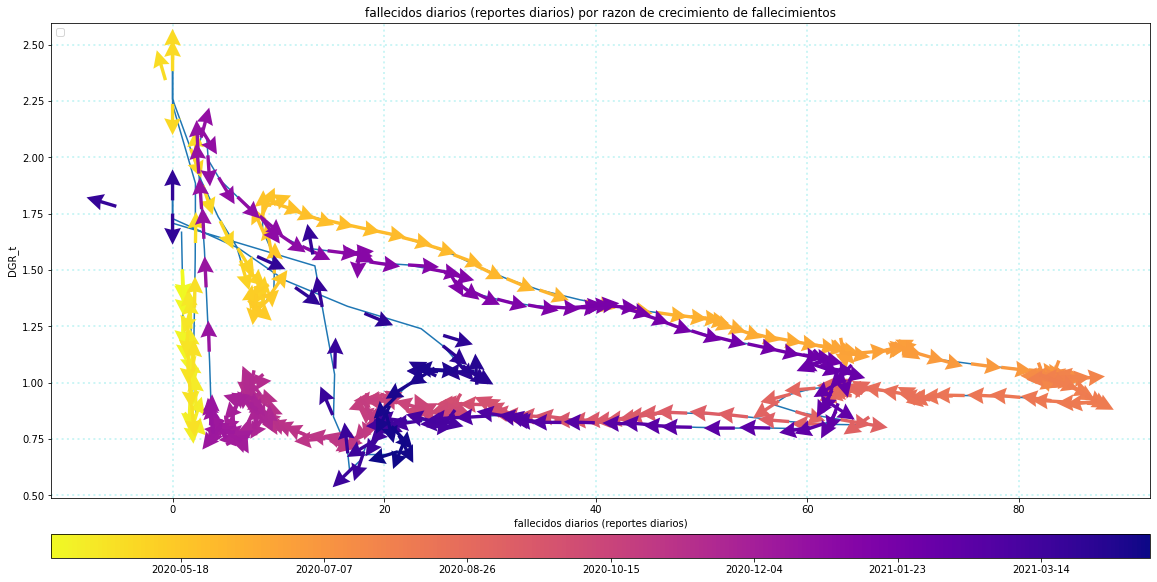

In [61]:
data_x = local_data.loc[:,pd.IndexSlice[:,'death']].sum(axis=1).diff()[:-6]
data_y = pd.Series(dgr_ts, index=data_x.index)


# data_x[data_x > 1000] = 100 # fix scz
data_x = data_x.rolling(window=3).mean()

data_x = fast_smoothing(data_x['2020-04-02':], .15)
data_y = fast_smoothing(data_y['2020-04-02':], .15)

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('fallecidos diarios (reportes diarios)')
ax.set_ylabel('DGR_t')

ax.set_title('fallecidos diarios (reportes diarios) por razon de crecimiento de fallecimientos')

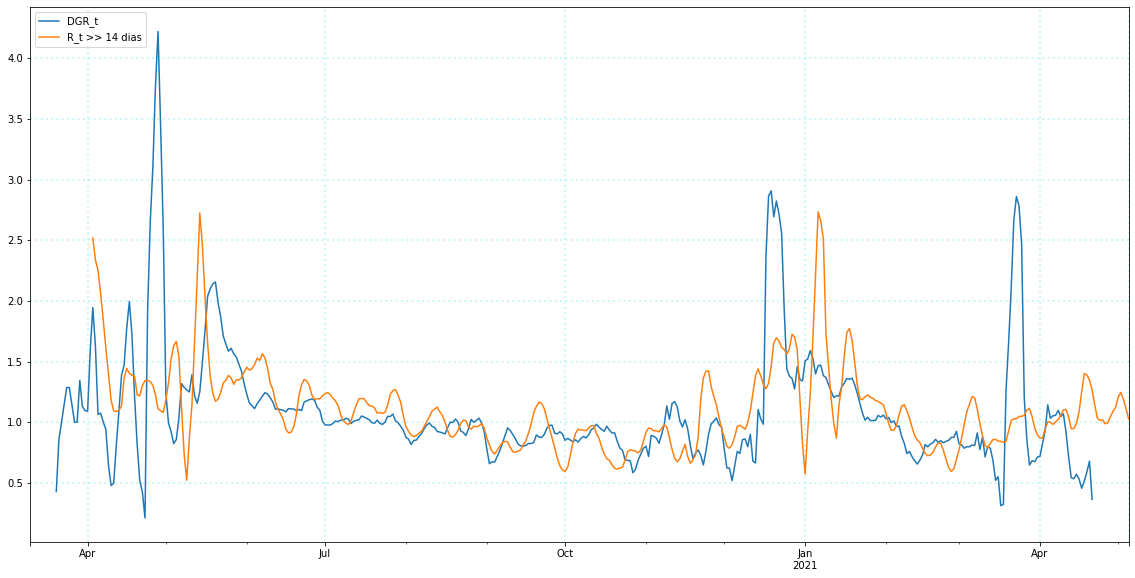

In [62]:
ax = pd.Series(dgr_ts, index=daily_deaths.index[:-6]).plot(label='DGR_t')
ax = pd.Series(r_ts['R_t'].values, index=daily_deaths.index[:-6] + pd.Timedelta(days=14)).plot(
    ax=ax, label='R_t >> 14 dias'
)

stylize_ax(ax)

No handles with labels found to put in legend.


Text(0, 0.5, 'R_t')

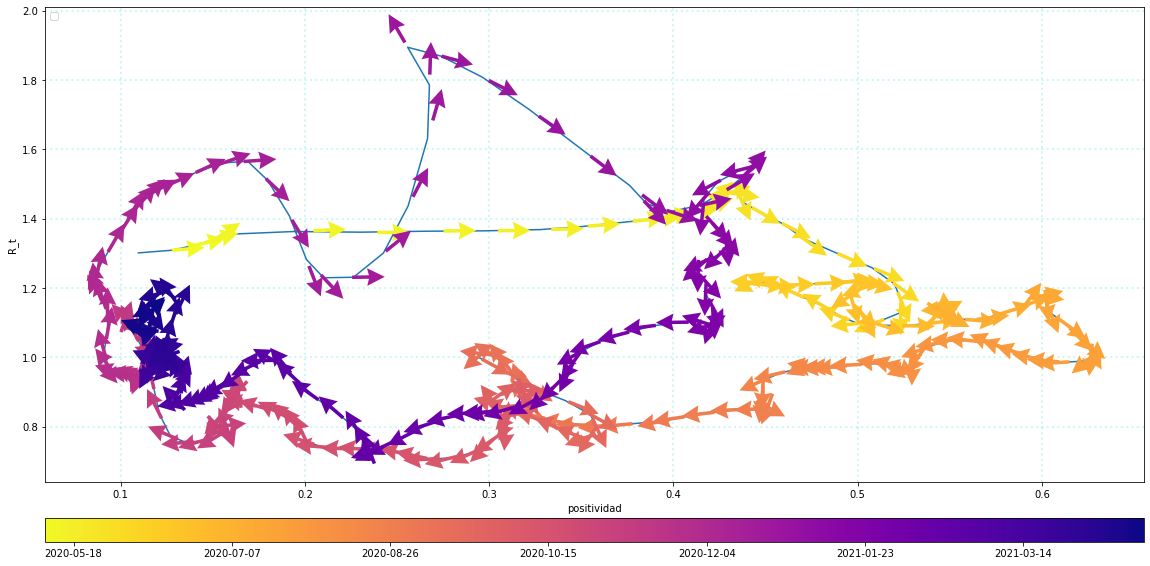

In [63]:
data_y = new_cases.rolling(window=5).sum() / daily_tests.rolling(window=5).sum()
data_y = data_y.iloc[:len(r_ts)]

data_x = r_ts['R_t']

data_x = fast_smoothing(data_x['2020-05-08':], .15)
data_y = fast_smoothing(data_y['2020-05-08':], .15)

data_x, data_y = data_y, data_x

ax = plot_quivered(data_x, data_y)
ax.set_xlabel('positividad')
ax.set_ylabel('R_t')

###### Comparativo II

In [64]:
START_DATE = pd.to_datetime('2020-11-13')

local_deaths_t = local_data.loc[:,pd.IndexSlice[:,'death']]['2020-11-11':]
local_deaths_t = local_deaths_t.diff().cumsum().iloc[1:]
local_deaths_t.columns = local_deaths_t.columns.droplevel(1)

local_deaths_adjusted_t = (local_deaths_t * population_adjust)
local_deaths_adjusted_t = local_deaths_adjusted_t[START_DATE:]

deaths_adjusted_t = local_deaths_t.sum(axis=1) * scale_to / sum(population.values())
deaths_adjusted_t = deaths_adjusted_t[START_DATE:]

In [65]:
local_cases_t = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']]['2020-11-11':]
local_cases_t = local_cases_t.diff().cumsum().iloc[1:]
local_cases_t.columns = local_cases_t.columns.droplevel(1)

cfr = (100 * local_deaths_t.rolling(window=3).sum() / local_cases_t.rolling(window=3).sum())
cfr[cfr == 0] = np.nan
cfr = cfr[START_DATE:]

In [66]:
local_population_t = local_population.loc['2020-11-11':].copy()
local_population_t.columns = local_population_t.columns.swaplevel(1, 0)

local_population_t['death'] = local_population_t['death'].diff().cumsum()

local_recovered = local_cases_t.shift(periods=14).fillna(0)

local_recovered = local_recovered - local_deaths_t
local_recovered.columns = pd.MultiIndex.from_product([
    ['recovered'], local_recovered.columns
])
local_recovered[local_recovered < 0] = 0

local_population_t.loc[:,['recovered']] = local_recovered
local_population_t.columns = local_population_t.columns.swaplevel(1, 0)

local_population_t = local_population_t.loc[START_DATE:]

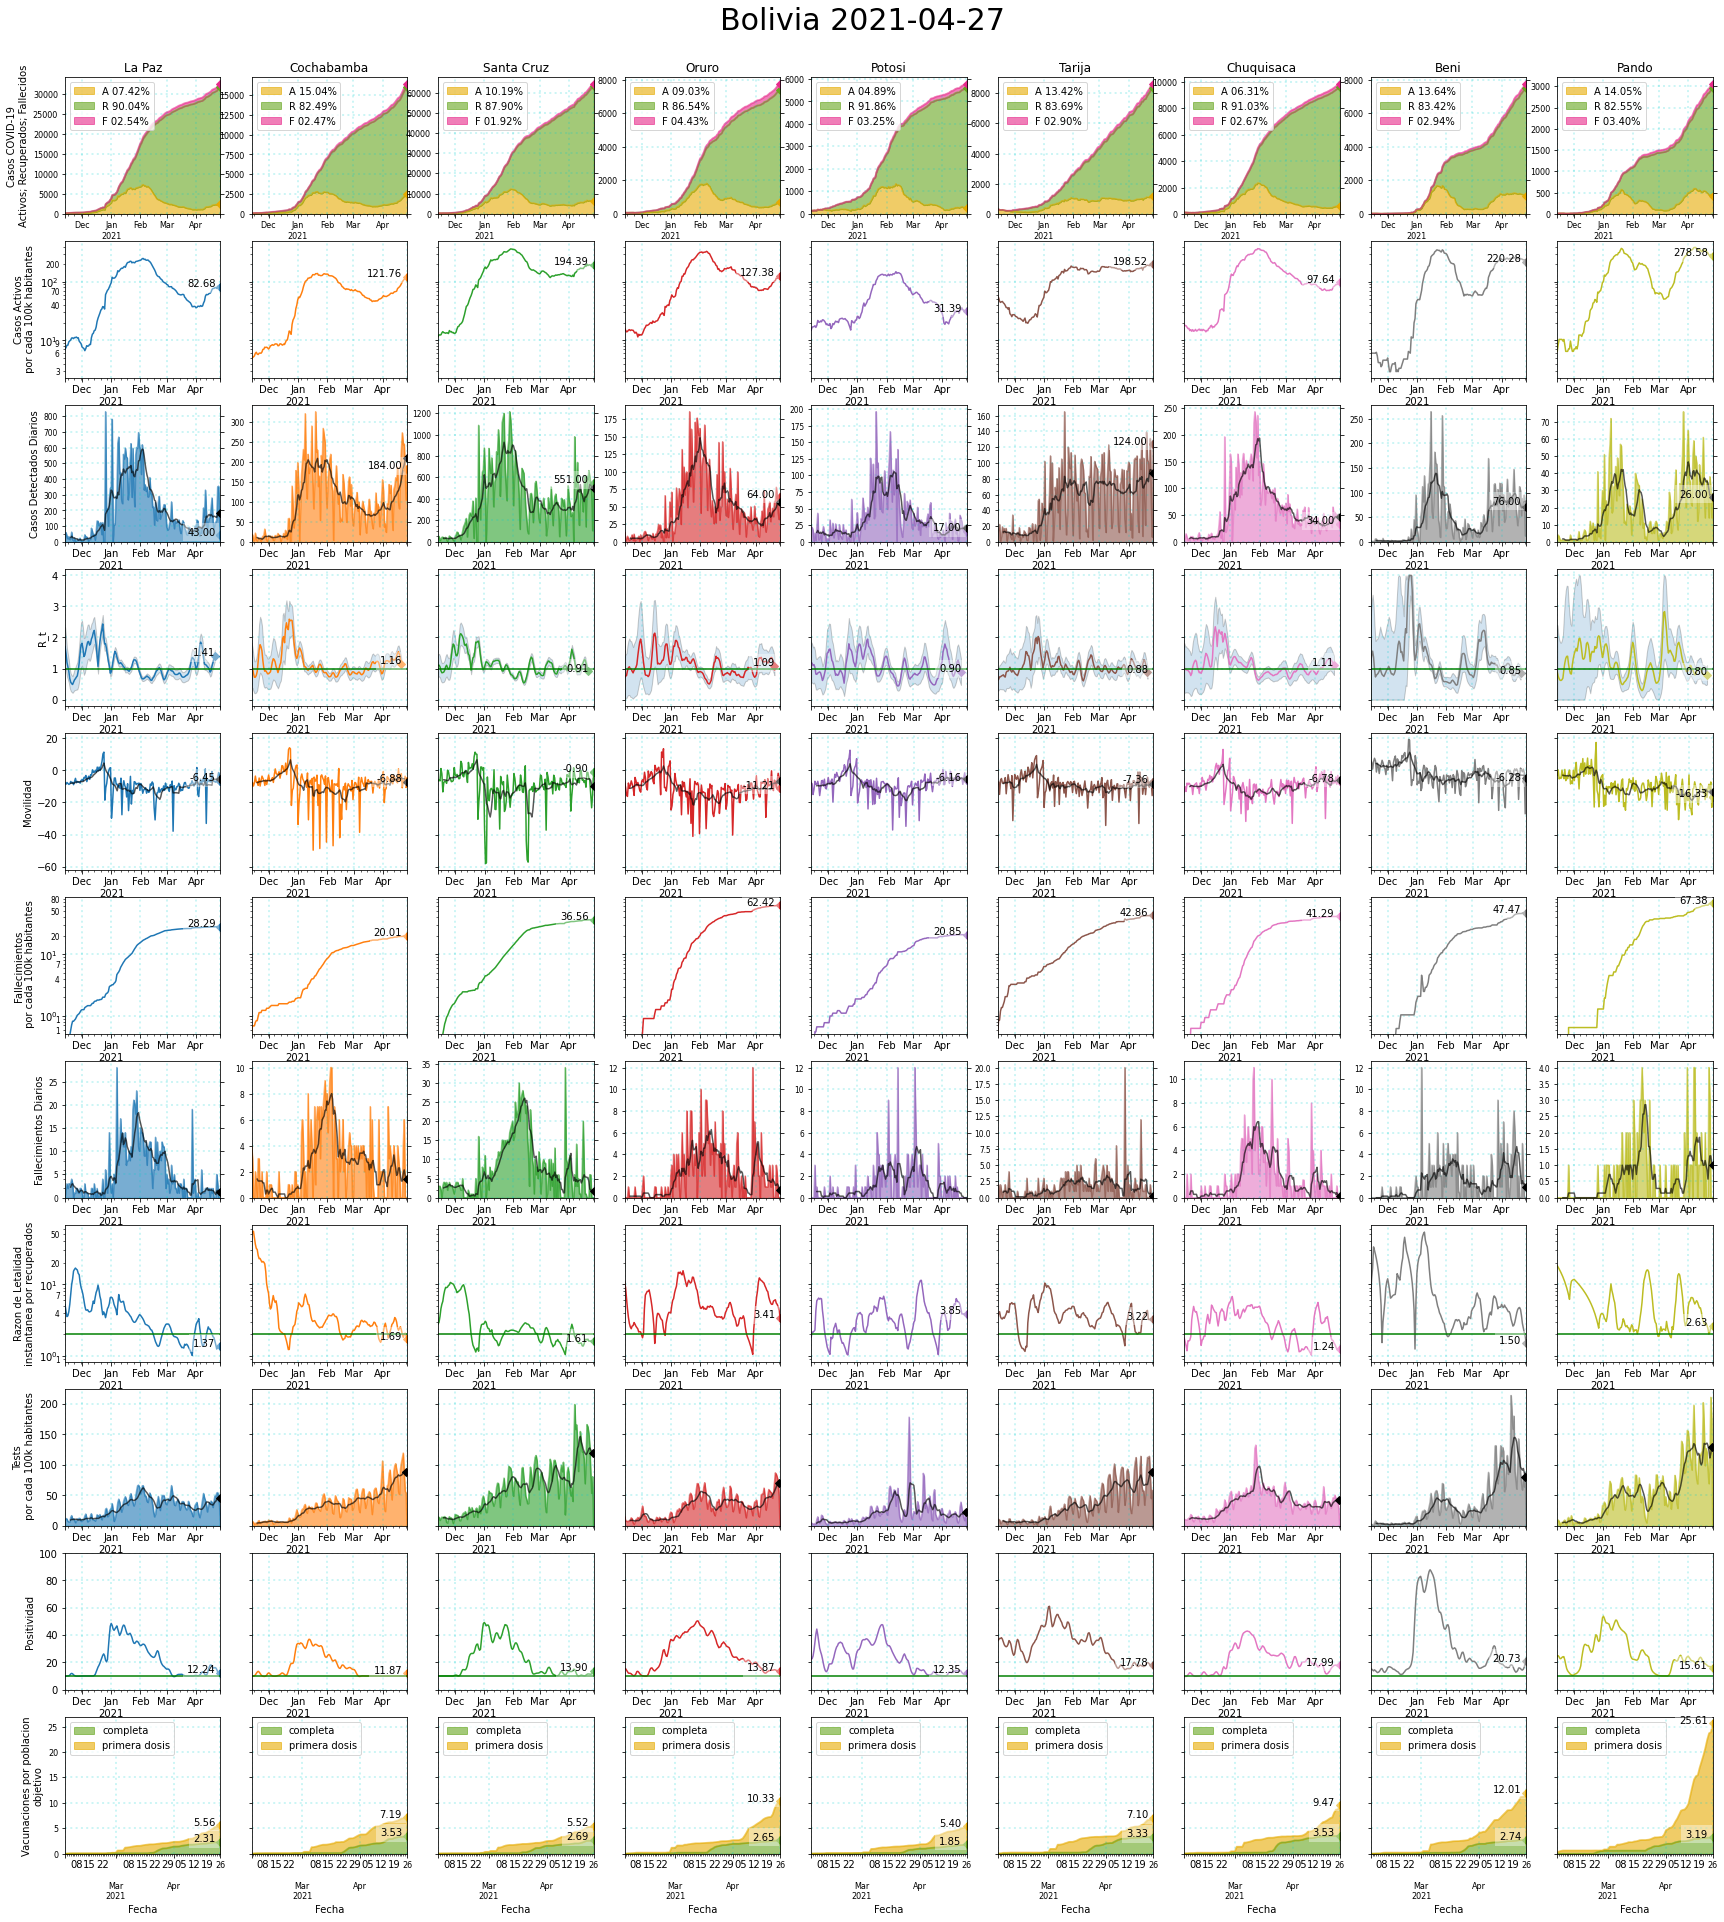

In [67]:
visited_tiles_change_local_timed = visited_tiles_change_local.tail(
    len(local_rts)
).iloc[:-1]
visited_tiles_change_local_timed.index = pd.to_datetime(
    visited_tiles_change_local_timed.index
)

if not visited_tiles_change_local_timed.iloc[-1].any():
    visited_tiles_change_local_timed = visited_tiles_change_local_timed.iloc[:-1]

VAR_NAMES = [
    'Casos COVID-19\nActivos; Recuperados; Fallecidos',
    'Casos Activos\n por cada 100k habitantes',
    'Casos Detectados Diarios',
    'R_t',
    'Movilidad',
    'Fallecimientos\n por cada 100k habitantes',
    'Fallecimientos Diarios',
    'Razon de Letalidad\ninstantanea por recuperados',
    'Tests\n por cada 100k habitantes',
    'Positividad',
#     'Saturacion de laboratorios',
    'Vacunaciones por poblacion\nobjetivo',
]

VARS = [
    (local_population_t, {
        'annotate': False,
        'sharey': False,
        'labeled': True,
    }),
    (local_active_cases_scaled, {'logy': True}),
    (local_new_cases, {
        'sharey': False, 
        'kind': 'area', 
        'alpha': .6,
        'averaged': True
    }),
    (local_rts, {'limit': (1, None)}),
    (100 * visited_tiles_change_local_timed.resample('D').mean(), {
        'averaged': True
    }),
    (local_deaths_adjusted_t, {'logy': True}),
    (local_daily_deaths, {
        'sharey': False, 
        'kind': 'area', 
        'alpha': .6,
        'averaged': True
    }),
    (local_weekly_cfr, {'limit': (2, None), 'logy': True}),
    (local_daily_tests_adjusted, {
        'kind': 'area', 
        'alpha': .6,
        'averaged': True,
    }),
    (fast_smooth_df(
        (100 / local_test_case_ratio).fillna(method='ffill')
    ), {'limit': (10., None), 'logy': False, 'ylimit': (0, 100)}),
#     (fast_smooth_df(
#         local_pending_tests_by_capacity
#     ), {'limit': (2, None), 'logy': True}),
    (vaccinations_local_doses_scaled, {'labeled': True}),
]

fig, axs = pyplot.subplots(
    ncols=9, 
    nrows=len(VARS), 
    sharey='row',
    figsize=(75/2.54, (80 + 3)/2.54)
)

for idx, row_axs in enumerate(axs):
    if type(VARS[idx]) == tuple:
        row_data, params = VARS[idx]
    else:
        row_data, params = VARS[idx], {}
    
    if START_DATE > row_data.index[0]:
        row_data = row_data.loc[START_DATE:]

    if idx == 0:
        row_data.plot = MethodType(local_population_plot, row_data)
    elif idx == 3:
        local_rts_base_plot = row_data.plot
        row_data.plot = MethodType(local_rts_plot, row_data)
            
    if 'sharey' in params:
        if not params['sharey']:
            shay = row_axs[0].get_shared_y_axes()
            for ax in row_axs:
                shay.remove(ax)
                yticker = matplotlib.axis.Ticker()
                
                ax.yaxis.major = yticker
                ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
                ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
                
                ax.tick_params(axis='y', reset=True, labelsize=7.5)
            
        del params['sharey']
    
    limit = None
    if 'limit' in params:
        limit = params['limit'] 
        del params['limit']
        
    ylimit = None
    if 'ylimit' in params:
        ylimit = params['ylimit']
        del params['ylimit']
        
    annotate = True
    if 'annotate' in params:
        annotate = params['annotate']
        del params['annotate']
        
    averaged = False
    if 'averaged' in params:
        averaged = params['averaged'] 
        del params['averaged']
        
    if 'labeled' in params and params['labeled']:
        for ax in row_axs:
            ax.labeled = params['labeled']
            
        del params['labeled']
                
    row_data.plot(ax=row_axs, subplots=True, **params)
    stylize_subplots_axs(row_axs, annotate=annotate)
    
    if averaged:
        averaged_data = row_data.rolling(window=7).mean()
        averaged_data.plot(
            ax=row_axs, 
            subplots=True, 
            color='black',
            alpha=.66
        )
        stylize_subplots_axs(row_axs, annotate=False)
        
    for ax in row_axs:
        if ylimit is not None:
            ax.set_ylim(ylimit)
        
        if 'logy' in params:
            ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
            for idx, tick in enumerate(ax.yaxis.get_minor_ticks()):
                if idx % 3 == 0:
                    tick.label1.set_fontsize(7.5)
                    continue

                tick.label1.set_visible(False)
    
        if not ax.get_lines():
            continue
            
        label = ax.get_lines()[0].get_label()
        if label in row_data and not row_data[label].any():
            ax.text(
                0.5, 0.5, 
                'Sin Datos', 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes
            )
    # :S
    if limit is not None:
        lgood, lbad = limit
        
        if lgood is not None:
            for ax in row_axs:
                ax.axhline(lgood, color='green')
                
        if lbad is not None:
            for ax in row_axs:
                ax.axhline(lbad, color='red')
    
for yax in axs:
    for ax in yax:
        if not ax.get_legend() or ('labeled' in dir(ax) and ax.labeled):
            continue
            
        ax.get_legend().remove()

for ax, col in zip(axs[0], local_rts.columns.str.title()):
    ax.set_title(col)
    
for ax, row in zip(axs[:, 0], VAR_NAMES):
    ax.set_ylabel(row)

fig.suptitle(today.strftime('Bolivia %Y-%m-%d'), fontsize=30, y=.91)

fig.savefig('./img/latest.png', bbox_inches='tight')
fig.savefig('./img/latest.jpeg', bbox_inches='tight')


Datos que faltarian:
* Porcentaje de los detectados diarios que son contactos de un infectado ya detectado.
    * Nro de contactos o si fuera posible, distribucion del # de contactos registrados.
    * Lugares donde se dan esas transmisiones (hogar, trabajo, reunion, ...) relacionado al # de contactos (buscando clusters)
* Porcentaje de detectados diarios que pertenecen a instituciones de cuidado (asilos, orfanatos) y en general (carceles, batallones).
* Ocupacion de camas hospitales, cuidados intermedios, terapia intensiva, aislados en centros (como en <a href='https://github.com/mauforonda/covid19-lapaz-establecimientos'>La Paz</a>)
* Porcentaje de los fallecidos que no fueron atendidos en hospital o fallecieron a poco de llegar.  
* Historico de fallecimientos estos meses, historico de fallecimientos de otros anhos.